In [8]:
# Step 1: Setup and Configuration

# Importing libraries for data handling, visualization, and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, precision_recall_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings

# Setting random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Setting visualization styles and sizes
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

# Suppressing warning messages
warnings.filterwarnings('ignore')

# Defining file paths
TRAINING_DATA_PATH = 'training_dataset.csv'
ANALYSIS_DATA_PATH = 'analysis_dataset.csv'

# Confirming setup
print("Setup complete.")

Setup complete.


In [2]:
# Step 2: Checking Datasets

# Loading preprocessed training dataset
print("Loading preprocessed datasets...")
train_df = pd.read_csv(TRAINING_DATA_PATH)
print(f"Training dataset loaded with shape: {train_df.shape}")

# Loading analysis dataset
analysis_df = pd.read_csv(ANALYSIS_DATA_PATH)
print(f"Analysis dataset loaded with shape: {analysis_df.shape}")

# Displaying structure and sample of training dataset
print("\n--- Training Dataset Overview ---")
print(train_df.info())
print("\nSample of training data:")
print(train_df.head())
print("\nDescriptive statistics of training data:")
print(train_df.describe())

# Displaying target variable distribution
target_distribution = train_df['significant_delay'].value_counts(normalize=True) * 100
print("\nTarget variable distribution:")
print(f"True (Significant Delay): {target_distribution.get(True, 0):.2f}%")
print(f"False (No Significant Delay): {target_distribution.get(False, 0):.2f}%")

# Displaying structure and sample of analysis dataset
print("\n--- Analysis Dataset Overview ---")
print(analysis_df.info())
print("\nSample of analysis data:")
print(analysis_df.head())
print("\nDescriptive statistics of analysis data:")
print(analysis_df.describe())

# Checking for missing values in both datasets
print("\nMissing values in training dataset:")
print(train_df.isnull().sum().sum())
print("\nMissing values in analysis dataset:")
print(analysis_df.isnull().sum().sum())


Loading preprocessed datasets...
Training dataset loaded with shape: (397948, 27)
Analysis dataset loaded with shape: (347, 48)

--- Training Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397948 entries, 0 to 397947
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   line                            397948 non-null  object 
 1   full_date                       397948 non-null  object 
 2   division_clean                  397948 non-null  object 
 3   significant_delay               397948 non-null  bool   
 4   delays                          397948 non-null  int64  
 5   year                            397948 non-null  int64  
 6   month                           397948 non-null  int64  
 7   day_of_month                    397948 non-null  int64  
 8   day_of_week                     397948 non-null  int64  
 9   is_weekend                      397948 

In [3]:
# Step 3: Loading Latest Processed Datasets and Creating Train/Test Split

# Importing required libraries
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Finding the latest output folder
output_folders = glob.glob("mta_analysis_output_*")
if not output_folders:
    raise ValueError("No output folders found with pattern 'mta_analysis_output_*'")

# Sorting to get the latest folder
latest_folder = sorted(output_folders)[-1]
print(f"Using latest output folder: {latest_folder}")

# Defining file paths
TRAINING_DATA_PATH = f"{latest_folder}/training_dataset.csv"
ANALYSIS_DATA_PATH = f"{latest_folder}/analysis_dataset.csv"

# Loading training dataset
print("Loading preprocessed datasets...")
train_df = pd.read_csv(TRAINING_DATA_PATH)
print(f"Training dataset loaded with shape: {train_df.shape}")

# Loading analysis dataset
analysis_df = pd.read_csv(ANALYSIS_DATA_PATH)
print(f"Analysis dataset loaded with shape: {analysis_df.shape}")

# Removing 'delays' column if present
if 'delays' in train_df.columns:
    print("\nWARNING: Found 'delays' column in training data - removing to prevent data leakage")
    train_df = train_df.drop(columns=['delays'])

# Confirming presence of 'delay_proxy' column
if 'delay_proxy' in train_df.columns:
    print("Confirmed: 'delay_proxy' found in training dataset as replacement for 'delays'")
else:
    print("Warning: 'delay_proxy' column not found in training dataset")

# Handling missing and infinite values in analysis dataset
print("\nHandling any remaining missing values in analysis dataset...")

# Defining columns for imputation
delay_columns = ['avg_daily_delays', 'median_daily_delays', 'max_daily_delays', 
                 'std_daily_delays', 'days_with_data', 'pct_days_with_significant_delay', 
                 'pct_weekend_data', 'total_days', 'delay_per_ridership', 
                 'delay_impact_score', 'delay_equity_ratio']

# Replacing inf/-inf with NaN
analysis_df[delay_columns] = analysis_df[delay_columns].replace([np.inf, -np.inf], np.nan)

# Filling missing values with median
missing_counts = analysis_df[delay_columns].isna().sum()
if missing_counts.sum() > 0:
    print("Missing values found in these columns:")
    print(missing_counts[missing_counts > 0])
    
    for col in delay_columns:
        if missing_counts[col] > 0:
            median_value = analysis_df[col].median()
            analysis_df[col] = analysis_df[col].fillna(median_value)
            print(f"  Filled {missing_counts[col]} missing values in '{col}' with median: {median_value:.4f}")
else:
    print("No missing values found in key analysis columns")

# Creating train/test split
print("\nCreating train/test split...")

# Removing identifier and leakage columns
drop_columns = ['full_date']
if 'delay_proxy' in train_df.columns:
    print("Removing 'delay_proxy' column to prevent data leakage")
    drop_columns.append('delay_proxy')
    
X = train_df.drop(columns=['significant_delay'] + drop_columns, errors='ignore')
y = train_df['significant_delay']

# Splitting into training and testing sets
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Split shapes: X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Features being used: {X_train.columns.tolist()}")

# Indicating that preprocessing is already done
print("\nNo additional preprocessing needed - using preprocessed features")

# Saving the train/test split
output_dir = f"{latest_folder}/model_inputs"
os.makedirs(output_dir, exist_ok=True)
X_train.to_csv(f'{output_dir}/X_train_final.csv', index=False)
X_test.to_csv(f'{output_dir}/X_test_final.csv', index=False)
pd.DataFrame(y_train).to_csv(f'{output_dir}/y_train_final.csv', index=False)
pd.DataFrame(y_test).to_csv(f'{output_dir}/y_test_final.csv', index=False)

print(f"\nTrain/test split saved to {output_dir}")
print("Data loading and split completed.")


Using latest output folder: mta_analysis_output_20250504_175249
Loading preprocessed datasets...
Training dataset loaded with shape: (1233431, 27)
Analysis dataset loaded with shape: (347, 48)
Confirmed: 'delay_proxy' found in training dataset as replacement for 'delays'

Handling any remaining missing values in analysis dataset...
No missing values found in key analysis columns

Creating train/test split...
Removing 'delay_proxy' column to prevent data leakage
Split shapes: X_train: (986744, 24), X_test: (246687, 24)
Features being used: ['line', 'division_clean', 'year', 'month', 'day_of_month', 'day_of_week', 'is_weekend', 'is_monday', 'is_friday', 'is_saturday', 'is_sunday', 'season', 'reporting_category', 'subcategory', 'day_type', 'prev_day_delay', 'prev_week_delay', 'delay_avg_7day', 'cat_Crew Availability', 'cat_External Factors', 'cat_Infrastructure & Equipment', 'cat_Operating Conditions', 'cat_Planned ROW Work', 'cat_Police & Medical']

No additional preprocessing needed - u


Starting feature selection process...
Features being considered: ['line', 'division_clean', 'year', 'month', 'day_of_month', 'day_of_week', 'is_weekend', 'is_monday', 'is_friday', 'is_saturday', 'is_sunday', 'season', 'reporting_category', 'subcategory', 'day_type', 'prev_day_delay', 'prev_week_delay', 'delay_avg_7day', 'cat_Crew Availability', 'cat_External Factors', 'cat_Infrastructure & Equipment', 'cat_Operating Conditions', 'cat_Planned ROW Work', 'cat_Police & Medical']
Original shape: (986744, 24)

Categorical features: ['line', 'division_clean', 'season', 'reporting_category', 'subcategory']
Numerical features: ['year', 'month', 'day_of_month', 'day_of_week', 'is_weekend', 'is_monday', 'is_friday', 'is_saturday', 'is_sunday', 'day_type', 'prev_day_delay', 'prev_week_delay', 'delay_avg_7day']


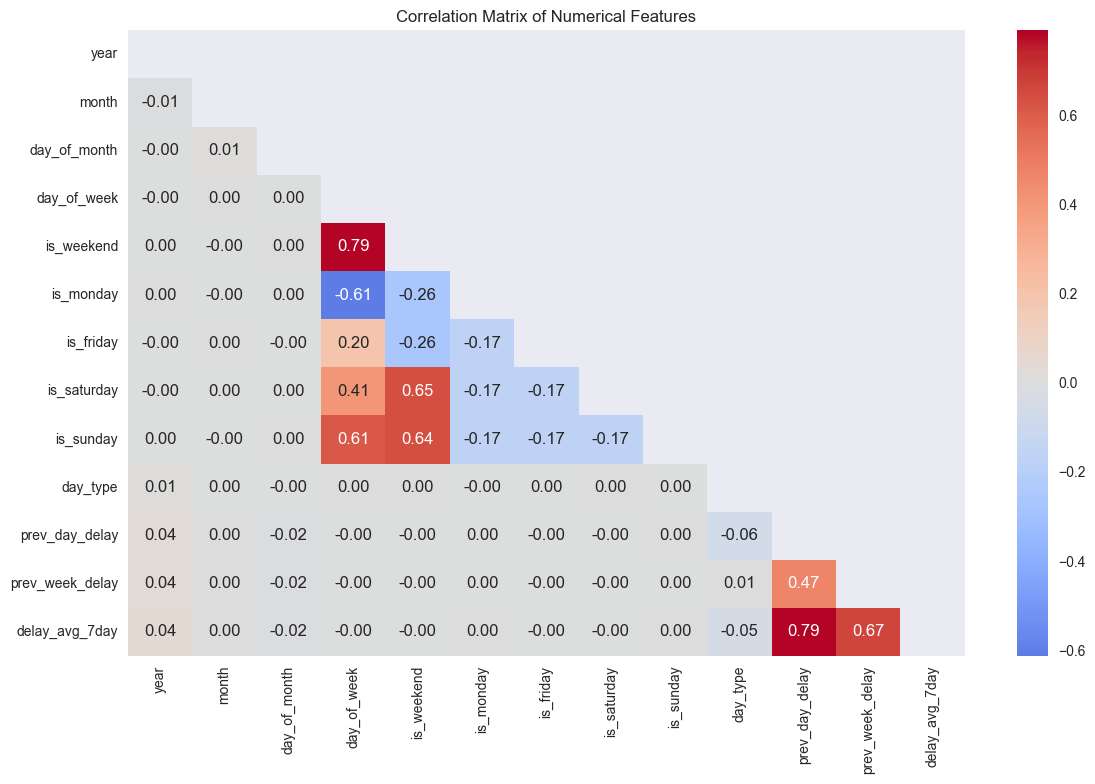

Highly correlated feature pairs (|corr| > 0.6):
  day_of_week and is_weekend: 0.7909
  day_of_week and is_monday: -0.6130
  day_of_week and is_sunday: 0.6122
  is_weekend and is_saturday: 0.6458
  is_weekend and is_sunday: 0.6448
  prev_day_delay and delay_avg_7day: 0.7912
  prev_week_delay and delay_avg_7day: 0.6695

Features dropped based on correlation: ['is_sunday', 'prev_day_delay']
Shape after correlation-based selection: (986744, 22)
Features remaining: 22

Training Random Forest to determine feature importance...
Shape after one-hot encoding: (986744, 74)


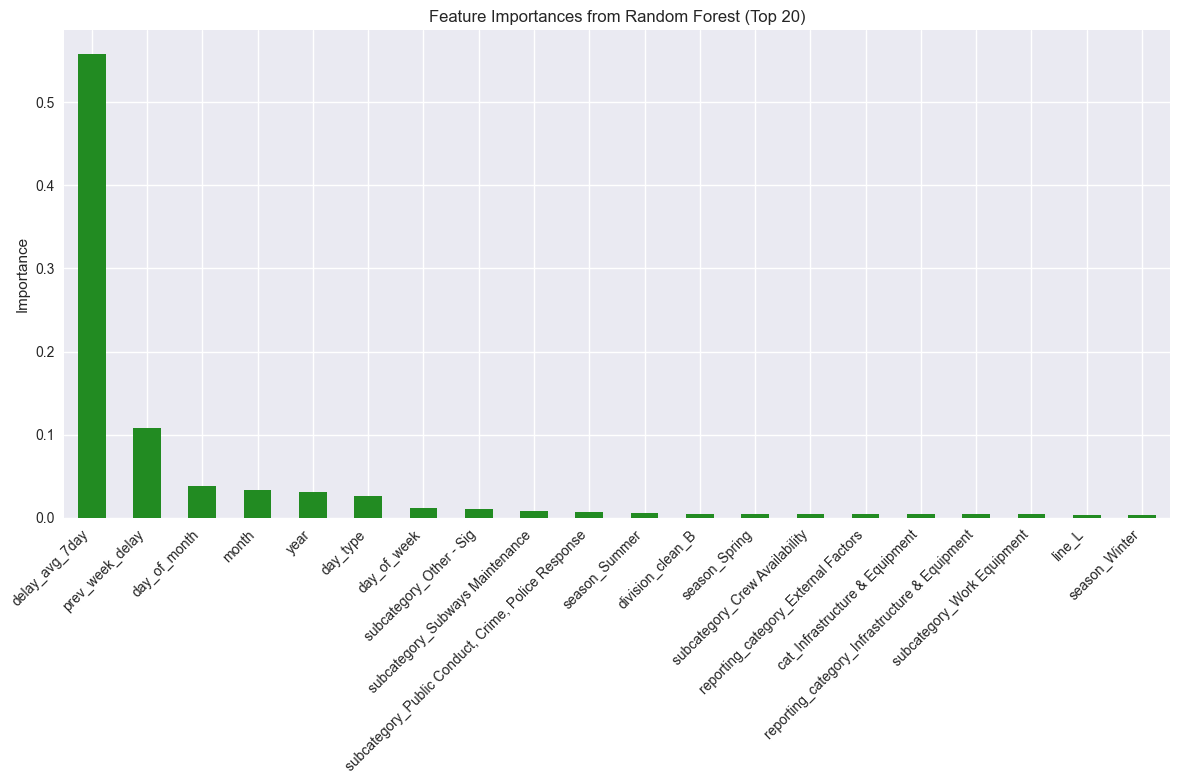


Top 20 Most Important Features for Predicting Significant Delays:
  1. delay_avg_7day: 0.5583
  2. prev_week_delay: 0.1078
  3. day_of_month: 0.0379
  4. month: 0.0335
  5. year: 0.0314
  6. day_type: 0.0266
  7. day_of_week: 0.0125
  8. subcategory_Other - Sig: 0.0101
  9. subcategory_Subways Maintenance: 0.0087
  10. subcategory_Public Conduct, Crime, Police Response: 0.0075
  11. season_Summer: 0.0053
  12. division_clean_B: 0.0050
  13. season_Spring: 0.0047
  14. subcategory_Crew Availability: 0.0046
  15. reporting_category_External Factors: 0.0044
  16. cat_Infrastructure & Equipment: 0.0043
  17. reporting_category_Infrastructure & Equipment: 0.0042
  18. subcategory_Work Equipment: 0.0042
  19. line_L: 0.0041
  20. season_Winter: 0.0040

Selected categorical features: ['line', 'division_clean', 'season', 'reporting_category', 'subcategory']
Selected non-categorical features: ['year', 'month', 'day_of_month', 'day_of_week', 'day_type', 'prev_week_delay', 'delay_avg_7day', 'cat

In [4]:
# Step 4: Feature Selection

print("\nStarting feature selection process...")
print("Features being considered:", X_train.columns.tolist())
print(f"Original shape: {X_train.shape}")

# Separating categorical and numerical features
categorical_features = ['line', 'division_clean', 'season', 'reporting_category', 'subcategory']
numerical_features = [col for col in X_train.columns if col not in categorical_features 
                     and not col.startswith('cat_')]

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Computing correlation matrix for numerical features
corr_matrix = X_train[numerical_features].corr()

# Visualizing correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_matrix_selection.png', dpi=300, bbox_inches='tight')
plt.show()

# Identifying highly correlated feature pairs
threshold = 0.6
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs (|corr| > 0.6):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} and {feat2}: {corr:.4f}")
else:
    print("  No highly correlated pairs found")

# Deciding features to drop based on correlation analysis
features_to_drop = []
if 'is_sunday' in X_train.columns and 'day_of_week' in X_train.columns:
    if any(pair[0] == 'day_of_week' and pair[1] == 'is_sunday' for pair in high_corr_pairs) or \
       any(pair[1] == 'day_of_week' and pair[0] == 'is_sunday' for pair in high_corr_pairs):
        features_to_drop.append('is_sunday')

if 'delay_avg_7day' in X_train.columns:
    for pair in high_corr_pairs:
        feat1, feat2, _ = pair
        if 'delay_avg_7day' in (feat1, feat2):
            other_feat = feat2 if feat1 == 'delay_avg_7day' else feat1
            if abs(pair[2]) > 0.75:
                features_to_drop.append(other_feat)

# Dropping highly correlated features
X_train_corr = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_corr = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"\nFeatures dropped based on correlation: {features_to_drop}")
print("Shape after correlation-based selection:", X_train_corr.shape)
print("Features remaining:", X_train_corr.shape[1])

# Training Random Forest for feature importance
print("\nTraining Random Forest to determine feature importance...")

# One-hot encoding categorical variables
X_train_rf = pd.get_dummies(X_train_corr, columns=categorical_features, drop_first=True)
X_test_rf = pd.get_dummies(X_test_corr, columns=categorical_features, drop_first=True)

# Aligning train and test datasets
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='outer', axis=1, fill_value=0)

print(f"Shape after one-hot encoding: {X_train_rf.shape}")

# Fitting Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train)

# Extracting feature importance
importances = pd.Series(rf.feature_importances_, index=X_train_rf.columns).sort_values(ascending=False)

# Plotting top feature importances
plt.figure(figsize=(12, 8))
importances.head(20).plot(kind='bar', color='forestgreen')
plt.title('Feature Importances from Random Forest (Top 20)')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

# Printing top 20 features
print("\nTop 20 Most Important Features for Predicting Significant Delays:")
for i, (feature, importance) in enumerate(importances.head(20).items(), 1):
    print(f"  {i}. {feature}: {importance:.4f}")

# Selecting top N features
n_to_select = 20
selected_features = importances.head(n_to_select).index.tolist()

# Identifying related categorical features
selected_categorical_features = []
for cat_feature in categorical_features:
    if any(feat.startswith(f"{cat_feature}_") for feat in selected_features):
        selected_categorical_features.append(cat_feature)

# Identifying selected numerical and binary features
selected_non_cat_features = [feat for feat in selected_features 
                           if not any(feat.startswith(f"{cat_feature}_") for cat_feature in categorical_features)]
selected_non_cat_features = [feat for feat in X_train.columns 
                           if feat in selected_non_cat_features or
                              (feat.startswith('cat_') and feat in selected_features)]

# Displaying selected feature breakdown
print("\nSelected categorical features:", selected_categorical_features)
print("Selected non-categorical features:", selected_non_cat_features)

# Creating datasets with selected features
print("\n--- Creating datasets with selected features ---")

X_train_selected = pd.get_dummies(
    X_train[selected_categorical_features + selected_non_cat_features], 
    columns=selected_categorical_features, 
    drop_first=True
)

X_test_selected = pd.get_dummies(
    X_test[selected_categorical_features + selected_non_cat_features], 
    columns=selected_categorical_features, 
    drop_first=True
)

# Aligning final datasets
X_train_selected, X_test_selected = X_train_selected.align(X_test_selected, join='outer', axis=1, fill_value=0)

print(f"Selected features dataset shapes: X_train_selected: {X_train_selected.shape}, X_test_selected: {X_test_selected.shape}")

# Saving feature importance data
output_dir = f"{latest_folder}/model_inputs"
os.makedirs(output_dir, exist_ok=True)
feature_importance_df = pd.DataFrame({
    'Feature': importances.index,
    'Importance': importances.values
})
feature_importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)

print("\nFeature importance analysis completed.")
print(f"Feature importance saved to {output_dir}/feature_importance.csv")



--- BASELINE MODELS ---
Majority Class Predictor Performance:
Accuracy: 0.6244
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000


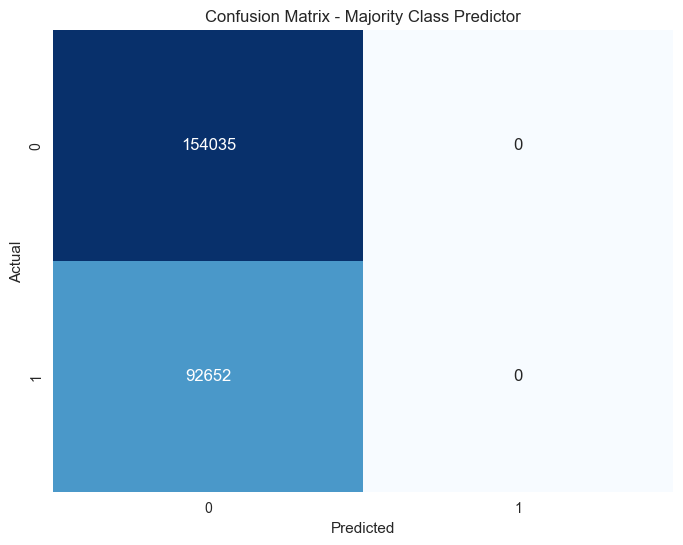


Top 5 features for Logistic Regression: ['delay_avg_7day', 'prev_week_delay', 'day_of_month', 'month', 'year']

Basic Logistic Regression Performance (Top 5 Features):
Accuracy: 0.8519
Precision: 0.8390
Recall: 0.7495
F1-Score: 0.7917
AUC-ROC: 0.9408


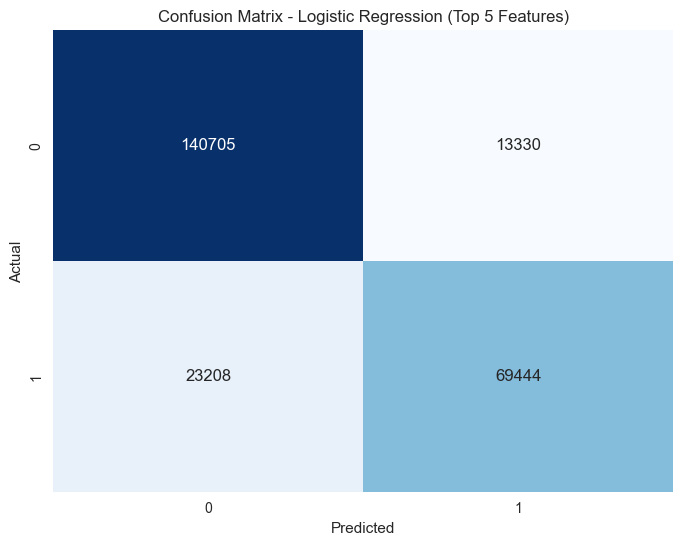


Logistic Regression Coefficients:
           Feature  Coefficient
0   delay_avg_7day     7.227652
3            month     0.000745
2     day_of_month    -0.000702
4             year    -0.001587
1  prev_week_delay    -0.769425

Baseline model evaluation completed.


In [9]:
# Step 5: Baseline Model

print("\n--- BASELINE MODELS ---")

# Training Dummy Classifier using majority class strategy
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_selected, y_train)

# Predicting and evaluating with Dummy Classifier
y_pred_dummy = dummy.predict(X_test_selected)
y_proba_dummy = dummy.predict_proba(X_test_selected)[:, 1]

print("Majority Class Predictor Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dummy):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dummy):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_dummy):.4f}")

# Visualizing confusion matrix for Dummy Classifier
cm_dummy = confusion_matrix(y_test, y_pred_dummy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Majority Class Predictor')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm_majority_class.png', dpi=300, bbox_inches='tight')
plt.show()

# Selecting top 5 features from feature importances
top_5_features = importances.head(5).index.tolist()
print("\nTop 5 features for Logistic Regression:", top_5_features)

# Preparing data for Logistic Regression using top 5 features
X_train_lr = X_train_selected[top_5_features]
X_test_lr = X_test_selected[top_5_features]

# Training Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_lr, y_train)

# Predicting and evaluating with Logistic Regression
y_pred_lr = lr.predict(X_test_lr)
y_proba_lr = lr.predict_proba(X_test_lr)[:, 1]

print("\nBasic Logistic Regression Performance (Top 5 Features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Visualizing confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression (Top 5 Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm_logistic_regression.png', dpi=300, bbox_inches='tight')
plt.show()

# Displaying feature coefficients for interpretability
coef_df = pd.DataFrame({
    'Feature': top_5_features,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Coefficients:")
print(coef_df)

print("\nBaseline model evaluation completed.")


Features in X_train_selected: ['year', 'month', 'day_of_month', 'day_of_week', 'day_type', 'prev_week_delay', 'delay_avg_7day', 'cat_Infrastructure & Equipment', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_7', 'line_A', 'line_B', 'line_C', 'line_D', 'line_E', 'line_F', 'line_G', 'line_GS', 'line_JZ', 'line_L', 'line_M', 'line_N', 'line_Q', 'line_R', 'line_S Fkln', 'line_S Rock', 'division_clean_B', 'season_Spring', 'season_Summer', 'season_Winter', 'reporting_category_External Factors', 'reporting_category_Infrastructure & Equipment', 'reporting_category_Operating Conditions', 'reporting_category_Planned ROW Work', 'reporting_category_Police & Medical', 'subcategory_Capital Work - Other Planned ROW', 'subcategory_Crew Availability', 'subcategory_Door-Related', 'subcategory_External Agency or Utility', 'subcategory_External Debris on Roadbed', 'subcategory_Fire, Smoke, Debris', 'subcategory_Inclement Weather', 'subcategory_Insufficient Supplement Schedule', 'subcat

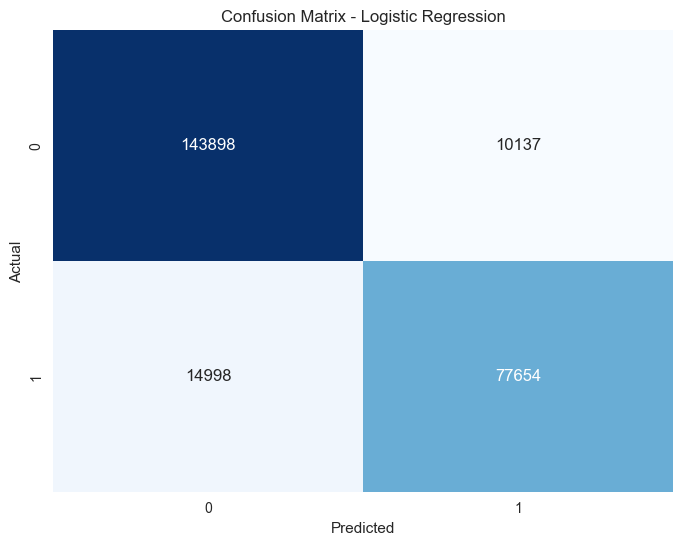


Training Random Forest...
Percentage of predicted significant delays: 40.04%
Actual percentage of significant delays: 37.56%


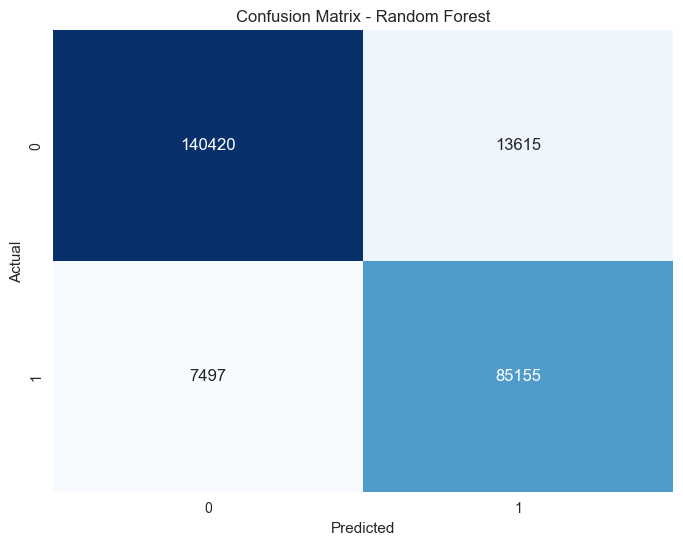


Training K-Nearest Neighbors...
Percentage of predicted significant delays: 34.83%
Actual percentage of significant delays: 37.56%


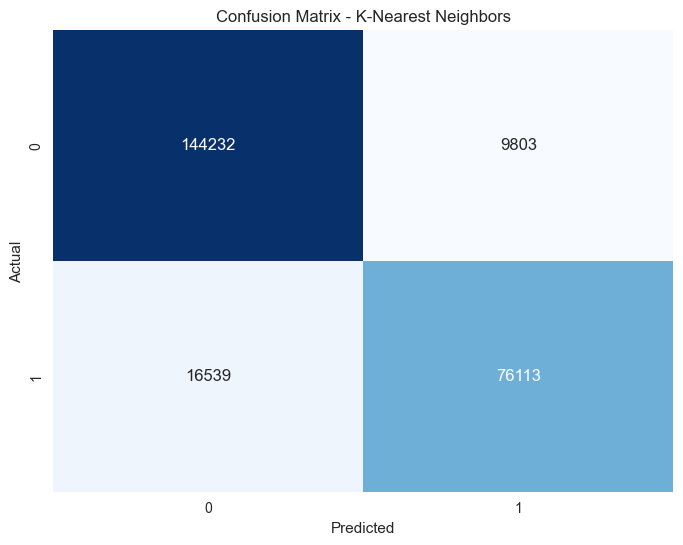


Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.898110   0.884533 0.838125  0.860704 0.960635
      Random Forest  0.914418   0.862155 0.919084  0.889710 0.977866
K-Nearest Neighbors  0.893217   0.885900 0.821493  0.852482 0.952437


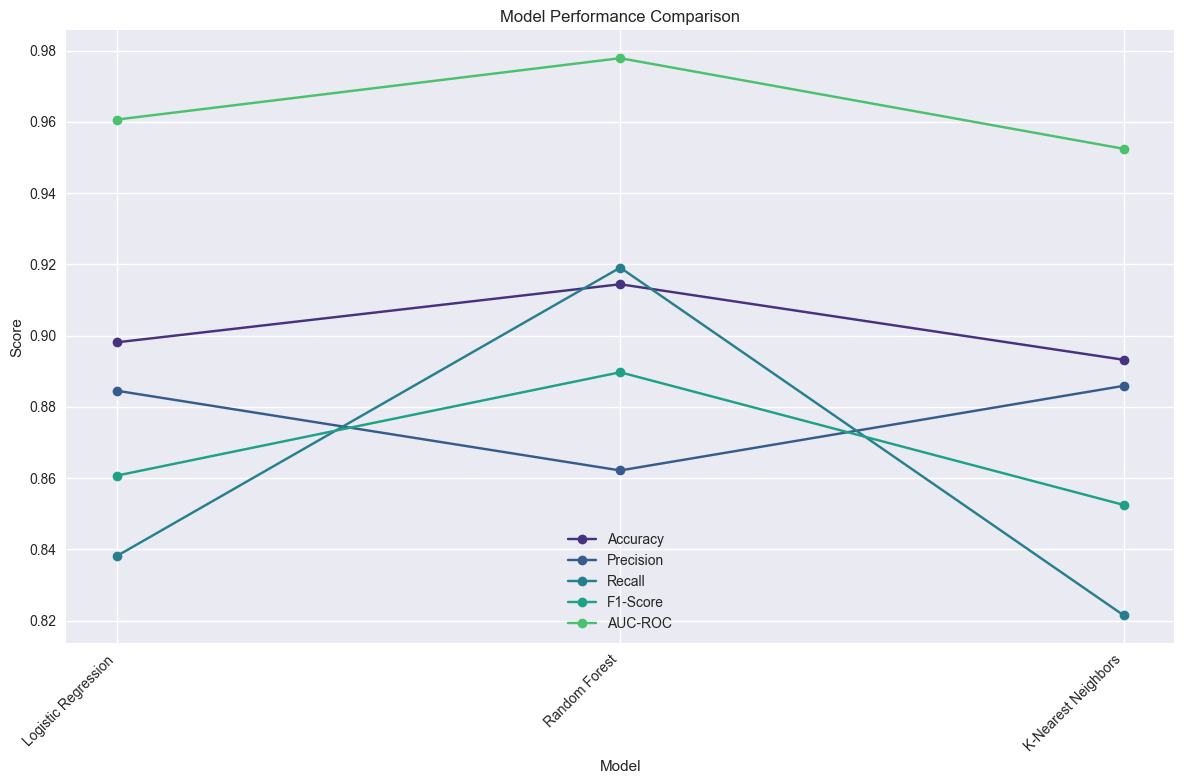

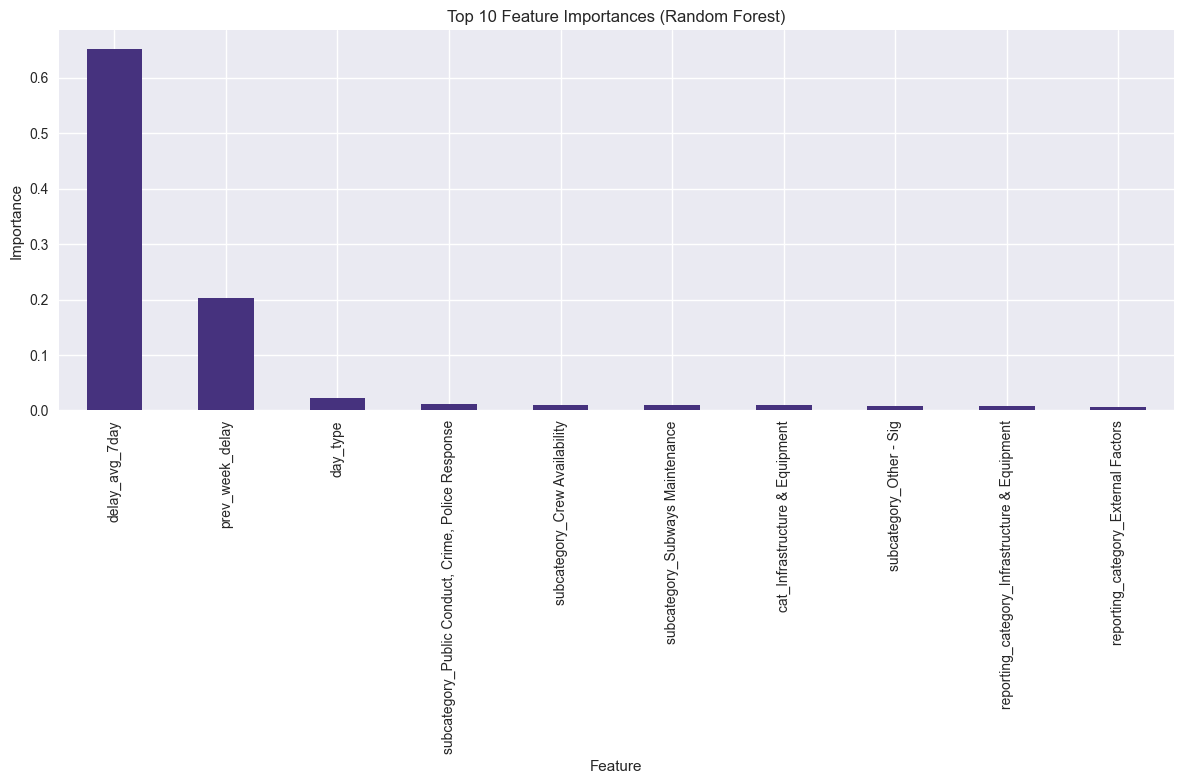


Top 10 Most Important Features (Random Forest):
1. delay_avg_7day: 0.6527
2. prev_week_delay: 0.2031
3. day_type: 0.0232
4. subcategory_Public Conduct, Crime, Police Response: 0.0124
5. subcategory_Crew Availability: 0.0102
6. subcategory_Subways Maintenance: 0.0093
7. cat_Infrastructure & Equipment: 0.0092
8. subcategory_Other - Sig: 0.0089
9. reporting_category_Infrastructure & Equipment: 0.0089
10. reporting_category_External Factors: 0.0062

Best model based on F1-Score: Random Forest
Best model saved as 'best_model.pkl'

Model training and comparison completed.


In [10]:
# Step 6: Model Training and Comparison

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Checking current feature set
print("Features in X_train_selected:", X_train_selected.columns.tolist())

# Defining models to train and compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

# Training models and evaluating performance
results = []
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Storing predictions
    predictions[name] = {
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    
    # Calculating metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }
    results.append(metrics)
    
    # Displaying predicted class distribution
    pred_positive = np.mean(y_pred)
    print(f"Percentage of predicted significant delays: {pred_positive*100:.2f}%")
    print(f"Actual percentage of significant delays: {np.mean(y_test)*100:.2f}%")
    
    # Plotting confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'cm_{name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Displaying model comparison table
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Visualizing model performance
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
plt.figure(figsize=(12, 8))
for metric in metrics_to_plot:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting feature importances from Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.Series(
        rf_model.feature_importances_,
        index=X_train_selected.columns
    ).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    feature_importance.head(10).plot(kind='bar')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features (Random Forest):")
    for i, (feature, importance) in enumerate(feature_importance.head(10).items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")

# Saving best model based on F1-Score
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest model based on F1-Score: {best_model_name}")

import joblib
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model saved as 'best_model.pkl'")

print("\nModel training and comparison completed.")


Confirmed: 'delays' feature is not present in the dataset
Features used for optimization: ['year', 'month', 'day_of_month', 'day_of_week', 'day_type', 'prev_week_delay', 'delay_avg_7day', 'cat_Infrastructure & Equipment', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_7', 'line_A', 'line_B', 'line_C', 'line_D', 'line_E', 'line_F', 'line_G', 'line_GS', 'line_JZ', 'line_L', 'line_M', 'line_N', 'line_Q', 'line_R', 'line_S Fkln', 'line_S Rock', 'division_clean_B', 'season_Spring', 'season_Summer', 'season_Winter', 'reporting_category_External Factors', 'reporting_category_Infrastructure & Equipment', 'reporting_category_Operating Conditions', 'reporting_category_Planned ROW Work', 'reporting_category_Police & Medical', 'subcategory_Capital Work - Other Planned ROW', 'subcategory_Crew Availability', 'subcategory_Door-Related', 'subcategory_External Agency or Utility', 'subcategory_External Debris on Roadbed', 'subcategory_Fire, Smoke, Debris', 'subcategory_Inclement Weath

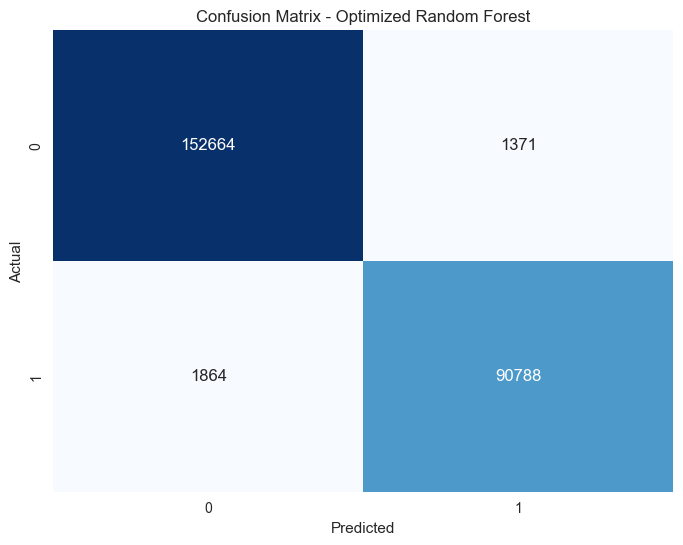


Cross-Validation F1-Scores: [0.97907378 0.97938207 0.97901208 0.9794617  0.97874875]
Mean CV F1-Score: 0.9791
Std CV F1-Score: 0.0003


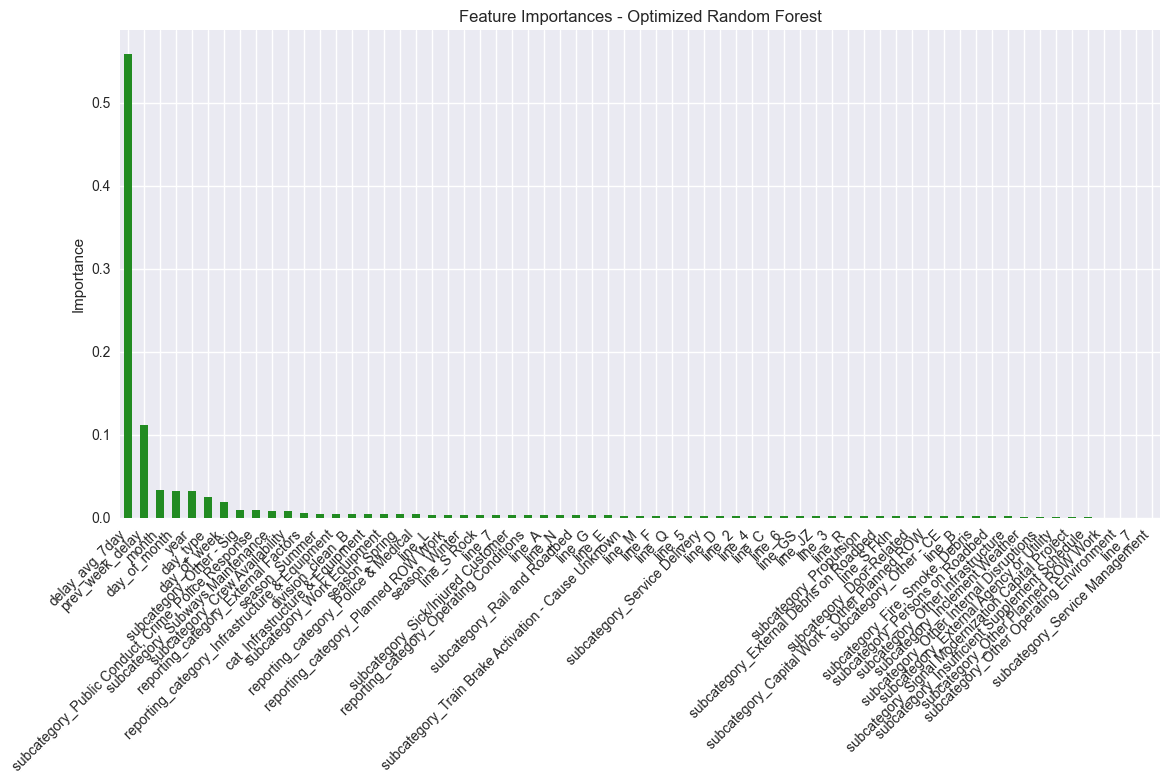


Top 10 Features by Importance:
1. delay_avg_7day: 0.5589
2. prev_week_delay: 0.1121
3. month: 0.0342
4. day_of_month: 0.0330
5. year: 0.0321
6. day_type: 0.0253
7. day_of_week: 0.0197
8. subcategory_Other - Sig: 0.0098
9. subcategory_Public Conduct, Crime, Police Response: 0.0093
10. subcategory_Subways Maintenance: 0.0088

Final optimized model saved as 'final_optimized_model.pkl'
Feature list saved as 'model_features.txt'

Model optimization and finalization completed.


In [11]:
# Step 7: Model Optimization and Finalization

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# Checking for 'delays' column to avoid data leakage
if 'delays' in X_train_selected.columns:
    print("WARNING: 'delays' feature found in dataset - removing to prevent data leakage")
    X_train_final = X_train_selected.drop(columns=['delays'])
    X_test_final = X_test_selected.drop(columns=['delays'])
else:
    print("Confirmed: 'delays' feature is not present in the dataset")
    X_train_final = X_train_selected
    X_test_final = X_test_selected

print(f"Features used for optimization: {X_train_final.columns.tolist()}")
print(f"Number of features: {X_train_final.shape[1]}")

# Performing hyperparameter tuning with GridSearchCV
print("\nPerforming hyperparameter tuning with GridSearchCV...")
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_final, y_train)

# Retrieving best model from grid search
best_rf = grid_search.best_estimator_
print("\nBest Random Forest Parameters:", grid_search.best_params_)
print("Best F1-Score from GridSearchCV:", grid_search.best_score_)

# Evaluating best model on test set
y_pred_best = best_rf.predict(X_test_final)
y_proba_best = best_rf.predict_proba(X_test_final)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_best):.4f}")

# Displaying predicted class distribution
pred_positive = np.mean(y_pred_best)
print(f"Percentage of predicted significant delays: {pred_positive*100:.2f}%")
print(f"Actual percentage of significant delays: {np.mean(y_test)*100:.2f}%")

# Plotting confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Optimized Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm_optimized_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

# Performing cross-validation to evaluate stability
cv_scores = cross_val_score(best_rf, X_train_final, y_train, cv=5, scoring='f1', n_jobs=-1)
print("\nCross-Validation F1-Scores:", cv_scores)
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")
print(f"Std CV F1-Score: {cv_scores.std():.4f}")

# Plotting feature importances
importances = pd.Series(best_rf.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
importances.plot(kind='bar', color='forestgreen')
plt.title('Feature Importances - Optimized Random Forest')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importances_optimized_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# Displaying top 10 most important features
print("\nTop 10 Features by Importance:")
for i, (feature, importance) in enumerate(importances.head(10).items(), 1):
    print(f"{i}. {feature}: {importance:.4f}")

# Saving final optimized model
joblib.dump(best_rf, 'final_optimized_model.pkl')
print("\nFinal optimized model saved as 'final_optimized_model.pkl'")

# Saving list of features used by the model
with open('model_features.txt', 'w') as f:
    f.write('\n'.join(X_train_final.columns.tolist()))
print("Feature list saved as 'model_features.txt'")

print("\nModel optimization and finalization completed.")


=== 9. FINAL MODEL EVALUATION ===
Loading the saved optimized model from mta_analysis_output_20250504_175249/model_inputs/final_optimized_model.pkl...
Error: [Errno 2] No such file or directory: 'mta_analysis_output_20250504_175249/model_inputs/final_optimized_model.pkl'
Saved model not found, using the model from the previous step
Generating predictions...

--- Detailed Performance Metrics ---
Accuracy: 0.9869
Precision: 0.9851
Recall: 0.9799
F1-Score: 0.9825
AUC-ROC: 0.9991

--- Classification Report ---
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    154035
        True       0.99      0.98      0.98     92652

    accuracy                           0.99    246687
   macro avg       0.99      0.99      0.99    246687
weighted avg       0.99      0.99      0.99    246687



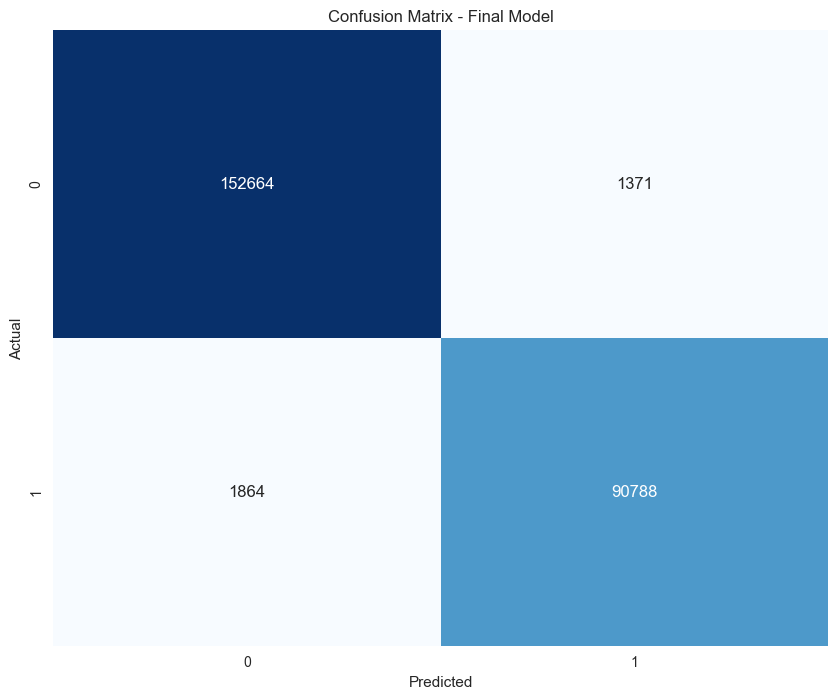

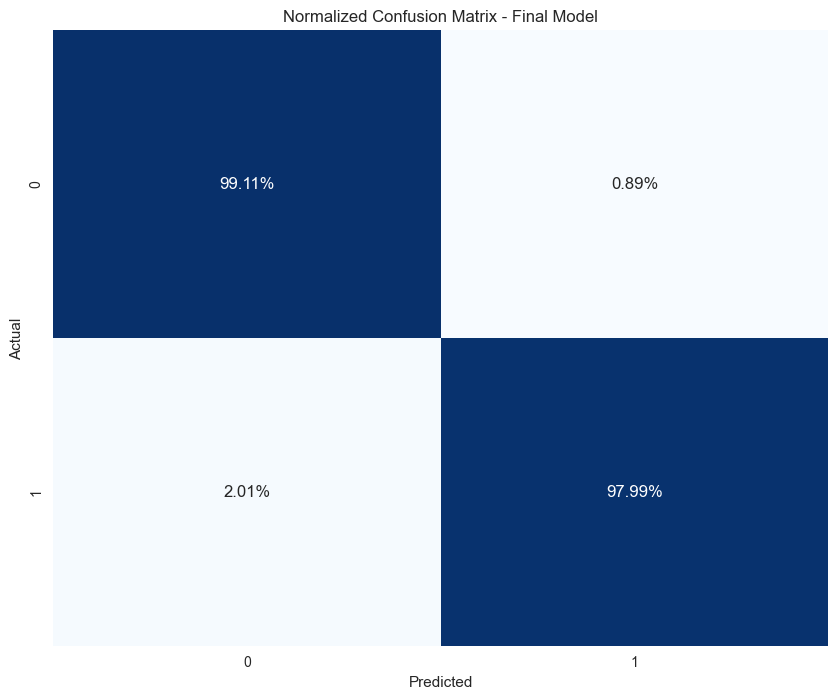

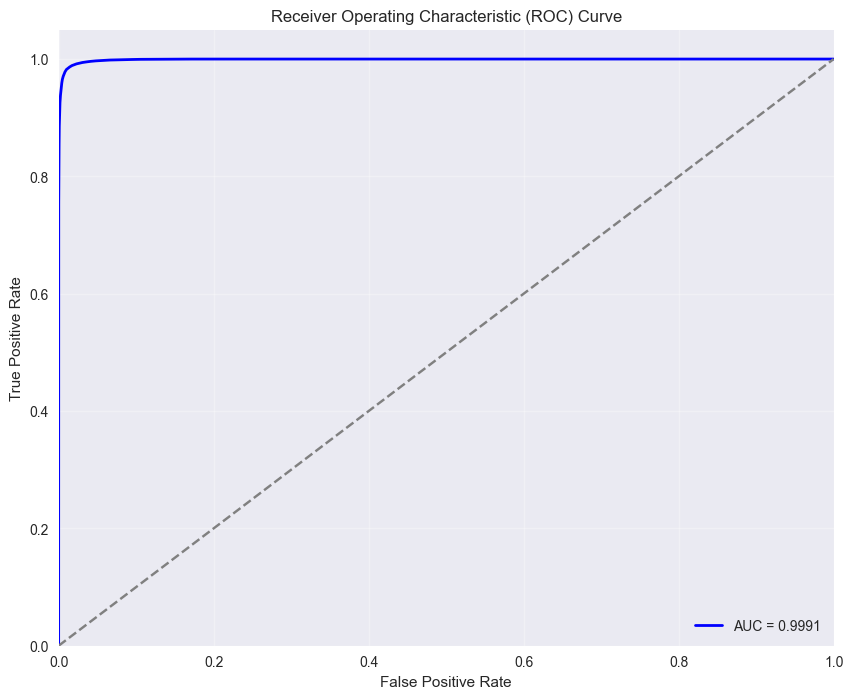

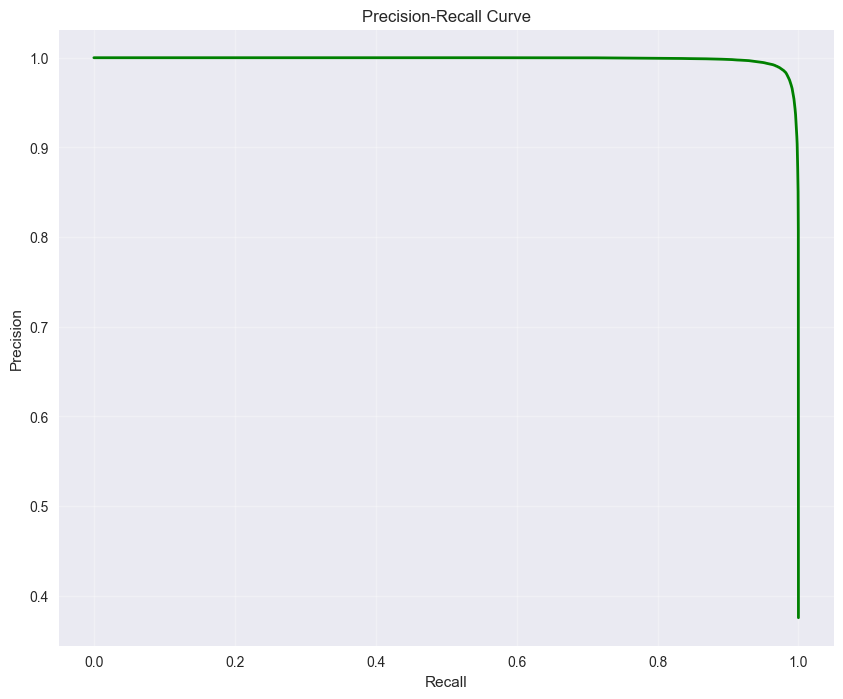


--- Performance by Threshold ---
 Threshold  Accuracy  Precision   Recall  F1-Score
       0.1  0.933928   0.850684 0.999525  0.919118
       0.2  0.966127   0.919316 0.997345  0.956742
       0.3  0.979634   0.954040 0.993643  0.973439
       0.4  0.985261   0.972645 0.988559  0.980537
       0.5  0.986882   0.984650 0.980357  0.982499
       0.6  0.984288   0.991453 0.966498  0.978816
       0.7  0.975990   0.995611 0.940217  0.967122
       0.8  0.961944   0.998098 0.900391  0.946730
       0.9  0.933904   0.999215 0.824666  0.903589


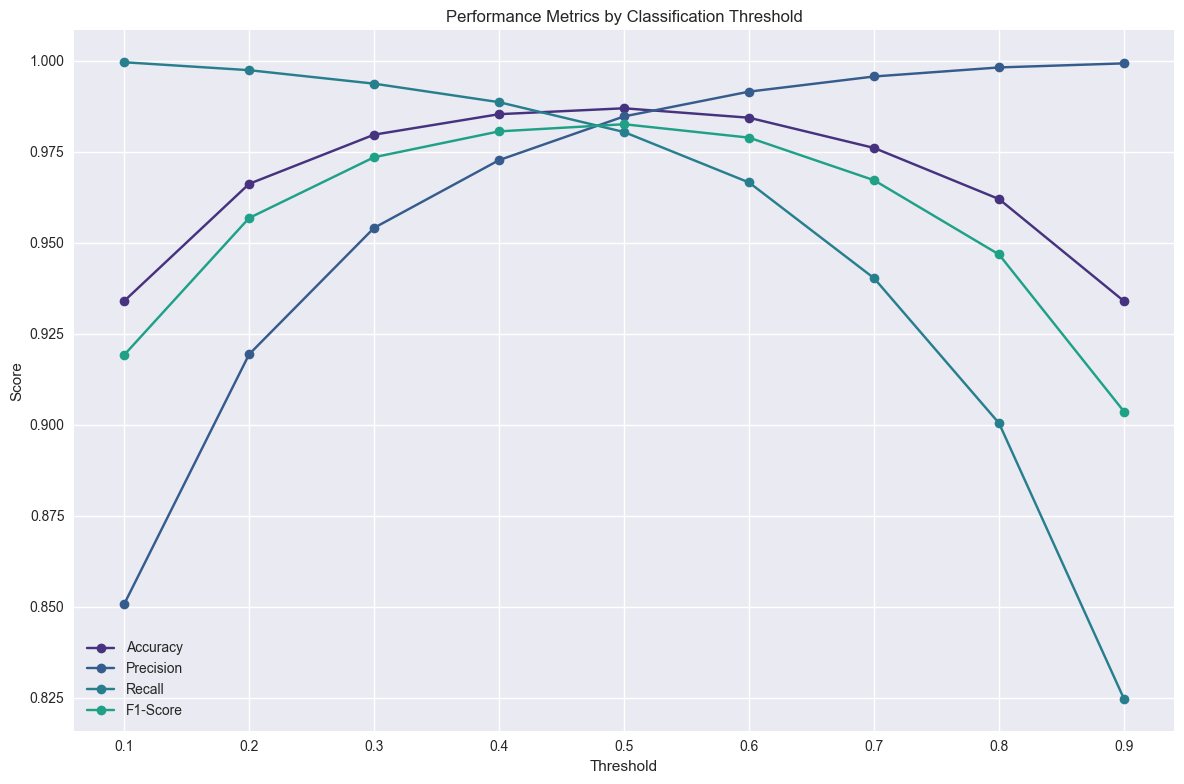


Optimal threshold for F1 score: 0.50
At this threshold, F1: 0.9825

Evaluation results saved to mta_analysis_output_20250504_175249/model_inputs/model_evaluation_results.txt

Final model evaluation completed.


In [14]:
# 8 Final Model Evaluation (REVISED)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                           confusion_matrix, classification_report, roc_curve, precision_recall_curve)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

print("=== 9. FINAL MODEL EVALUATION ===")

# Define paths relative to the output directory
output_dir = f"{latest_folder}/model_inputs"
model_path = f'{output_dir}/final_optimized_model.pkl'
feature_list_path = f'{output_dir}/model_features.txt'

# Load the finalized model from the previous step
try:
    print(f"Loading the saved optimized model from {model_path}...")
    best_rf = joblib.load(model_path)
    
    # Get the features used during training
    if os.path.exists(feature_list_path):
        with open(feature_list_path, 'r') as f:
            model_features = f.read().splitlines()
            print(f"Model features loaded from {feature_list_path}")
    else:
        # Try to extract feature names from the model
        model_features = best_rf.feature_names_in_
        print("Model features extracted from model object")
    
    print(f"Model loaded with {len(model_features)} features")
    
    # Ensure all required features are present in X_test_selected
    missing_features = [f for f in model_features if f not in X_test_selected.columns]
    if missing_features:
        print(f"WARNING: Missing features in test data: {missing_features}")
        
    # Create test dataset with the same features in the same order
    X_test_final = X_test_selected[model_features].copy()
    print("Test data prepared with matching features")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Saved model not found, using the model from the previous step")
    best_rf = grid_search.best_estimator_  # Use the model from GridSearchCV
    X_test_final = X_test_selected

# Predict on test set
print("Generating predictions...")
y_pred = best_rf.predict(X_test_final)
y_proba = best_rf.predict_proba(X_test_final)[:, 1]

# Detailed evaluation metrics
print("\n--- Detailed Performance Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix with percentages
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'{output_dir}/final_cm.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Normalized Confusion Matrix - Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'{output_dir}/final_cm_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_dir}/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze performance by threshold
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_proba >= threshold).astype(int)
    metrics = {
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred_threshold),
        'Precision': precision_score(y_test, y_pred_threshold, zero_division=0),
        'Recall': recall_score(y_test, y_pred_threshold),
        'F1-Score': f1_score(y_test, y_pred_threshold, zero_division=0)
    }
    threshold_metrics.append(metrics)

threshold_df = pd.DataFrame(threshold_metrics)
print("\n--- Performance by Threshold ---")
print(threshold_df.to_string(index=False))

# Visualize threshold impact
plt.figure(figsize=(12, 8))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(threshold_df['Threshold'], threshold_df[metric], marker='o', label=metric)
plt.title('Performance Metrics by Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/threshold_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate optimal threshold for F1 score
f1_scores = threshold_df['F1-Score']
optimal_idx = f1_scores.idxmax()
optimal_threshold = threshold_df.iloc[optimal_idx]['Threshold']
print(f"\nOptimal threshold for F1 score: {optimal_threshold:.2f}")
print(f"At this threshold, F1: {f1_scores.iloc[optimal_idx]:.4f}")

# Save the evaluation results to a file
eval_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_proba),
    'Optimal Threshold': optimal_threshold
}

with open(f'{output_dir}/model_evaluation_results.txt', 'w') as f:
    for metric, value in eval_results.items():
        f.write(f"{metric}: {value}\n")

print(f"\nEvaluation results saved to {output_dir}/model_evaluation_results.txt")
print("\nFinal model evaluation completed.")

In [17]:
# Step 9: Comprehensive Transit Equity Analysis - Numerical Results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu, chi2_contingency
import geopandas as gpd
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("=== 9. COMPREHENSIVE TRANSIT EQUITY ANALYSIS - NUMERICAL RESULTS ===")

# Verifying loaded data shapes
print("\nUsing existing data from memory...")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")
print(f"Analysis dataset shape: {analysis_df.shape}")

# Loading or rebuilding optimized model
print("\nLoading the optimized model...")
try:
    model_path = f"{output_dir}/final_optimized_model.pkl"
    if os.path.exists(model_path):
        best_rf = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
    else:
        print("Model file not found, rebuilding from optimized parameters")
        best_rf = RandomForestClassifier(
            n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1,
            random_state=42, class_weight='balanced', n_jobs=-1
        )
        best_rf.fit(X_train_selected, y_train)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Rebuilding model with optimized parameters...")
    best_rf = RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        random_state=42, class_weight='balanced', n_jobs=-1
    )
    best_rf.fit(X_train_selected, y_train)

# Verifying model performance
y_pred = best_rf.predict(X_test_selected)
y_proba = best_rf.predict_proba(X_test_selected)[:, 1]
print("Model Performance Verification:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# ----------------------------
# 1. Demographic Data Analysis
# ----------------------------
print("\n=== 1. DEMOGRAPHIC DATA ANALYSIS ===")

# Describing demographic statistics
print("\n--- 1.1 Demographic Variable Statistics ---")
demographic_stats = analysis_df[demo_columns].describe().transpose()
demographic_stats['cv'] = demographic_stats['std'] / demographic_stats['mean']
print(demographic_stats)

# Analyzing borough-level demographic averages
print("\n--- 1.2 Borough-Level Demographic Analysis ---")
borough_demo = analysis_df.groupby('borough_first')[demo_columns].mean()
print(borough_demo)

# Calculating demographic variable correlations
print("\n--- 1.3 Correlation Matrix of Demographic Variables ---")
demo_corr = analysis_df[demo_columns].corr()
corr_pairs = []
for i in range(len(demo_columns)):
    for j in range(i+1, len(demo_columns)):
        corr_pairs.append((demo_columns[i], demo_columns[j], demo_corr.iloc[i, j]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
print("Top 15 strongest correlations between demographic variables:")
for var1, var2, corr in corr_pairs[:15]:
    print(f"{var1} & {var2}: {corr:.4f}")

# Performing clustering on demographic profiles
print("\n--- 1.4 Demographic Clustering Analysis ---")
scaler = StandardScaler()
demo_scaled = scaler.fit_transform(analysis_df[demo_columns].fillna(0))
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(demo_scaled)
    wcss.append(kmeans.inertia_)
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
analysis_df['demographic_cluster'] = kmeans.fit_predict(demo_scaled)
cluster_profiles = analysis_df.groupby('demographic_cluster')[demo_columns].mean()
print("Demographic cluster profiles:")
print(cluster_profiles)
cluster_counts = analysis_df['demographic_cluster'].value_counts().sort_index()
print("\nNumber of stations in each demographic cluster:")
print(cluster_counts)

# Applying PCA on demographic features
print("\n--- 1.5 Principal Component Analysis of Demographics ---")
pca = PCA(n_components=3)
pca_result = pca.fit_transform(demo_scaled)
analysis_df['demo_pc1'] = pca_result[:, 0]
analysis_df['demo_pc2'] = pca_result[:, 1]
analysis_df['demo_pc3'] = pca_result[:, 2]
print("PCA explained variance by component:")
print(pca.explained_variance_ratio_)
print("\nPCA component loadings:")
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(3)], index=demo_columns)
print(pca_loadings)

# -----------------------------
# 2. Transit Service Reliability
# -----------------------------
print("\n=== 2. TRANSIT SERVICE RELIABILITY ANALYSIS ===")

# Displaying delay statistics by line and borough
print("\n--- 2.1 Delay Statistics by Transit Line ---")
line_stats = analysis_df.groupby('primary_line')[[
    'avg_daily_delays', 'pct_days_with_significant_delay', 
    'delay_per_ridership', 'delay_impact_score'
]].mean().sort_values('avg_daily_delays', ascending=False)
print(line_stats.head(10))

print("\n--- 2.2 Delay Statistics by Borough ---")
borough_stats = analysis_df.groupby('borough_first')[[
    'avg_daily_delays', 'pct_days_with_significant_delay', 
    'delay_per_ridership', 'delay_impact_score'
]].mean().sort_values('avg_daily_delays', ascending=False)
print(borough_stats)

# Creating reliability metrics
print("\n--- 2.3 Additional Reliability Metrics ---")
analysis_df['delay_cv'] = analysis_df['std_daily_delays'] / analysis_df['avg_daily_delays'].replace(0, 0.1)
analysis_df['delay_predictability'] = analysis_df['std_daily_delays'] / (analysis_df['median_daily_delays'] + 1)
analysis_df['delay_severity_ratio'] = analysis_df['max_daily_delays'] / (analysis_df['median_daily_delays'] + 1)
analysis_df['delay_frequency'] = analysis_df['pct_days_with_significant_delay'] * 100
analysis_df['reliability_score'] = (
    (analysis_df['delay_cv'].clip(0, 5) / 5) * 0.2 +
    (analysis_df['delay_predictability'].clip(0, 10) / 10) * 0.3 +
    (analysis_df['delay_severity_ratio'].clip(0, 20) / 20) * 0.2 +
    (analysis_df['delay_frequency'] / 100) * 0.3
)
print(analysis_df[[
    'delay_cv', 'delay_predictability', 'delay_severity_ratio', 
    'delay_frequency', 'reliability_score'
]].describe())

# Analyzing reliability by transfer status
print("\n--- 2.4 Transfer Station Reliability Analysis ---")
transfer_reliability = analysis_df.groupby('is_transfer_station')[[
    'avg_daily_delays', 'pct_days_with_significant_delay', 
    'delay_per_ridership', 'delay_impact_score', 'reliability_score'
]].mean()
print(transfer_reliability)

# Calculating correlations with station characteristics
print("\n--- 2.5 Correlation Between Station Metrics and Reliability ---")
corr_df = pd.DataFrame(index=station_features, columns=reliability_metrics)
for feat in station_features:
    for metric in reliability_metrics:
        if feat == 'is_transfer_station':
            corr, _ = pearsonr(analysis_df[feat].astype(int), analysis_df[metric])
        else:
            corr, _ = spearmanr(analysis_df[feat], analysis_df[metric], nan_policy='omit')
        corr_df.loc[feat, metric] = corr
print(corr_df)

# -----------------------------
# 3. Equity Impact Analysis
# -----------------------------
print("\n=== 3. EQUITY IMPACT ANALYSIS ===")

# Comparing delay metrics across income and race
print("\n--- 3.1 Delay Metrics by Income Quartile ---")
print(analysis_df.groupby('income_quartile')[[
    'avg_daily_delays', 'pct_days_with_significant_delay', 
    'delay_per_ridership', 'delay_impact_score', 'reliability_score'
]].mean())

# 3.2 Delay metrics by racial composition
print("\n--- 3.2 Delay Metrics by Racial Composition ---")
racial_comp_stats = analysis_df.groupby('racial_composition')[[
    'avg_daily_delays', 'pct_days_with_significant_delay',
    'delay_per_ridership', 'delay_impact_score', 'reliability_score'
]].mean()
print(racial_comp_stats)

# 3.3 Delay metrics by car dependency and transit usage
print("\n--- 3.3 Delay Metrics by Car Dependency and Transit Usage ---")
car_dependency_stats = analysis_df.groupby('car_dependency')[[
    'avg_daily_delays', 'pct_days_with_significant_delay',
    'delay_per_ridership', 'delay_impact_score', 'reliability_score'
]].mean()
print(car_dependency_stats)

transit_usage_stats = analysis_df.groupby('transit_usage')[[
    'avg_daily_delays', 'pct_days_with_significant_delay',
    'delay_per_ridership', 'delay_impact_score', 'reliability_score'
]].mean()
print(transit_usage_stats)

# 3.4 Disparate impact ratios
print("\n--- 3.4 Disparate Impact Analysis ---")

if set(income_categories).issubset(set(analysis_df['income_category'].unique())):
    low_income = analysis_df[analysis_df['income_category'] == 'Low']['reliability_score'].mean()
    high_income = analysis_df[analysis_df['income_category'] == 'High']['reliability_score'].mean()
    income_disparity_ratio = low_income / high_income if high_income > 0 else 0
    print(f"Income Disparity Ratio (Low/High): {income_disparity_ratio:.4f}")
else:
    print("Income categories not found for disparity ratio")

if 'majority_minority' in analysis_df.columns:
    minority_score = analysis_df[analysis_df['majority_minority']]['reliability_score'].mean()
    non_minority_score = analysis_df[~analysis_df['majority_minority']]['reliability_score'].mean()
    racial_disparity_ratio = minority_score / non_minority_score if non_minority_score > 0 else 0
    print(f"Racial Disparity Ratio (Majority-Minority/Non): {racial_disparity_ratio:.4f}")
else:
    print("No majority-minority flag found")

if 'car_dependency' in analysis_df.columns:
    car_independent_mask = analysis_df['car_dependency'].isin(['Car Independent', 'Low Car Dependency'])
    if car_independent_mask.any():
        car_indep = analysis_df[car_independent_mask]['reliability_score'].mean()
        car_dep = analysis_df[~car_independent_mask]['reliability_score'].mean()
        vehicle_disparity_ratio = car_indep / car_dep if car_dep > 0 else 0
        print(f"Vehicle Access Disparity Ratio (Car-Independent/Car-Dependent): {vehicle_disparity_ratio:.4f}")
    else:
        print("Expected car dependency categories not found")
else:
    print("Car dependency column not found")

# 3.5 Statistical significance testing
print("\n--- 3.5 Statistical Significance Testing ---")

if 'income_category' in analysis_df.columns:
    try:
        high = analysis_df[analysis_df['income_category'] == 'High']['reliability_score']
        low = analysis_df[analysis_df['income_category'] == 'Low']['reliability_score']
        t_stat, p_val = ttest_ind(high, low, equal_var=False, nan_policy='omit')
        print(f"T-test (High vs Low Income): t={t_stat:.4f}, p={p_val:.4f}")
        u_stat, p_val_u = mannwhitneyu(high, low, alternative='two-sided')
        print(f"Mann-Whitney U test: U={u_stat:.4f}, p={p_val_u:.4f}")
    except Exception as e:
        print(f"Income test error: {e}")

if 'majority_minority' in analysis_df.columns:
    try:
        min_grp = analysis_df[analysis_df['majority_minority']]['reliability_score']
        non_min_grp = analysis_df[~analysis_df['majority_minority']]['reliability_score']
        t_stat, p_val = ttest_ind(min_grp, non_min_grp, equal_var=False, nan_policy='omit')
        print(f"T-test (Race): t={t_stat:.4f}, p={p_val:.4f}")
        u_stat, p_val_u = mannwhitneyu(min_grp, non_min_grp, alternative='two-sided')
        print(f"Mann-Whitney U test: U={u_stat:.4f}, p={p_val_u:.4f}")
    except Exception as e:
        print(f"Race test error: {e}")

# 3.6 Multiple regression on demographic variables
print("\n--- 3.6 Multiple Regression Analysis of Demographic Effects ---")
try:
    import statsmodels.api as sm
    y_var = analysis_df['reliability_score']
    X_vars = analysis_df[['median_income', 'pct_white', 'pct_black', 'pct_hispanic', 
                          'pct_asian', 'pct_no_vehicle', 'transit_dependency_ratio']]
    X_vars = sm.add_constant(X_vars)
    model = sm.OLS(y_var, X_vars, missing='drop').fit()
    print(model.summary().tables[1])  # Only coefficient table
except Exception as e:
    print(f"Regression analysis error: {e}")

# -----------------------------
# 4. Economic Impact Analysis
# -----------------------------
print("\n=== 4. ECONOMIC IMPACT ANALYSIS ===")

# 4.1 Cost calculation
print("\n--- 4.1 Economic Cost Calculation ---")
AVG_WAGE_PER_HOUR = 25
AVG_DELAY_MINUTES = 15
WORK_TRIP_PCT = 0.65
VALUE_OF_TIME_FACTOR = {'High': 1.2, 'Medium-High': 1.0, 'Medium-Low': 0.9, 'Low': 0.8}

analysis_df['delay_minutes_per_year'] = analysis_df['avg_daily_delays'] * AVG_DELAY_MINUTES * 365
analysis_df['work_trips_affected'] = analysis_df['ridership_mean'] * WORK_TRIP_PCT * analysis_df['pct_days_with_significant_delay']
analysis_df['value_of_time_factor'] = analysis_df['income_category'].map(lambda x: VALUE_OF_TIME_FACTOR.get(x, 1.0))

analysis_df['annual_econ_cost'] = (
    analysis_df['delay_minutes_per_year'] / 60 *
    AVG_WAGE_PER_HOUR *
    analysis_df['work_trips_affected'] *
    analysis_df['value_of_time_factor']
)

denominator = analysis_df['median_income'] * analysis_df['total_households']
analysis_df['relative_econ_burden'] = np.where(denominator > 0,
                                               analysis_df['annual_econ_cost'] / denominator,
                                               np.nan)

analysis_df['relative_econ_burden'] = analysis_df['relative_econ_burden'].replace([np.inf, -np.inf], np.nan)
median_val = analysis_df['relative_econ_burden'].median()
analysis_df['relative_econ_burden'] = analysis_df['relative_econ_burden'].fillna(median_val)
print(f"Replaced missing values in burden column with median: {median_val:.6f}")

# Economic statistics
print("\nEconomic cost statistics:")
econ_stats = analysis_df[['annual_econ_cost', 'relative_econ_burden']].describe()
print(econ_stats)

# 4.2 Economic impact by groups
print("\n--- 4.2 Economic Impact by Demographic Group ---")
print("\nBy Income Category:")
print(analysis_df.groupby('income_category')[[
    'annual_econ_cost', 'relative_econ_burden', 'work_trips_affected'
]].mean())

print("\nBy Racial Composition:")
print(analysis_df.groupby('racial_composition')[[
    'annual_econ_cost', 'relative_econ_burden', 'work_trips_affected'
]].mean())

print("\nBy Car Dependency:")
print(analysis_df.groupby('car_dependency')[[
    'annual_econ_cost', 'relative_econ_burden', 'work_trips_affected'
]].mean())

# 4.3 Total system-wide cost and per-capita by borough
total_annual_cost = analysis_df['annual_econ_cost'].sum()
print(f"\nTotal estimated annual economic cost: ${total_annual_cost:,.2f}")

print("\nCost per capita by borough:")
borough_cost = analysis_df.groupby('borough_first').apply(
    lambda x: pd.Series({
        'total_annual_cost': x['annual_econ_cost'].sum(),
        'population': x['total_population'].sum(),
        'cost_per_capita': x['annual_econ_cost'].sum() / x['total_population'].sum()
    })
)
print(borough_cost)

# -------------------------------------------
# 5. ACCESSIBILITY AND MOBILITY IMPACT ANALYSIS
# -------------------------------------------
print("\n=== 5. ACCESSIBILITY AND MOBILITY IMPACT ANALYSIS ===")

# 5.1 Basic accessibility metrics
print("\n--- 5.1 Basic Accessibility Metrics ---")

# Define accessibility score
analysis_df['base_accessibility_score'] = (
    analysis_df['num_lines'] * 2 +  # More lines = more accessibility
    (analysis_df['is_transfer_station'] * 5) +  # Transfer stations provide more connectivity
    (analysis_df['ridership_mean'] / 100)  # Higher ridership indicates more service
)

# Accessibility impact from delays
analysis_df['accessibility_loss_pct'] = (
    analysis_df['pct_days_with_significant_delay'] * 
    (0.3 + 0.5 * (analysis_df['avg_daily_delays'] / analysis_df['avg_daily_delays'].quantile(0.95)))
).clip(0, 1)  # Cap at 100% loss

analysis_df['accessibility_score_with_delays'] = analysis_df['base_accessibility_score'] * (1 - analysis_df['accessibility_loss_pct'])

# Normalized scores (0-100 scale)
max_base = analysis_df['base_accessibility_score'].max()
analysis_df['accessibility_index'] = (analysis_df['base_accessibility_score'] / max_base * 100).clip(0, 100)
analysis_df['accessibility_index_with_delays'] = (analysis_df['accessibility_score_with_delays'] / max_base * 100).clip(0, 100)

print(analysis_df[['base_accessibility_score', 'accessibility_loss_pct', 
                  'accessibility_index', 'accessibility_index_with_delays']].describe())

# 5.2 Accessibility loss by demographic group
print("\n--- 5.2 Accessibility Loss by Demographic Group ---")

# By income
access_by_income = analysis_df.groupby('income_category')[
    ['accessibility_index', 'accessibility_index_with_delays', 'accessibility_loss_pct']
].mean()
access_by_income['absolute_access_loss'] = access_by_income['accessibility_index'] - access_by_income['accessibility_index_with_delays']
print("\nAccessibility metrics by income category:")
print(access_by_income)

# By racial composition
access_by_race = analysis_df.groupby('racial_composition')[
    ['accessibility_index', 'accessibility_index_with_delays', 'accessibility_loss_pct']
].mean()
access_by_race['absolute_access_loss'] = access_by_race['accessibility_index'] - access_by_race['accessibility_index_with_delays']
print("\nAccessibility metrics by racial composition:")
print(access_by_race)

# By car dependency
access_by_car = analysis_df.groupby('car_dependency')[
    ['accessibility_index', 'accessibility_index_with_delays', 'accessibility_loss_pct']
].mean()
access_by_car['absolute_access_loss'] = access_by_car['accessibility_index'] - access_by_car['accessibility_index_with_delays']
print("\nAccessibility metrics by car dependency:")
print(access_by_car)

# 5.3 Mobility limitation impact
print("\n--- 5.3 Mobility Limitation Impact ---")

# Calculate mobility limitation index
analysis_df['mobility_limitation_score'] = (
    (analysis_df['pct_no_vehicle'] / 100) *  # Higher for areas with fewer vehicles
    (1 - (analysis_df['pct_walk'] / 100)) *  # Lower for areas where walking is more viable
    (analysis_df['pct_public_transit'] / 100)  # Higher for transit-dependent areas
)

# Calculate the compound effect of delays on mobility-limited populations
analysis_df['mobility_impact_index'] = (
    analysis_df['mobility_limitation_score'] * 
    analysis_df['accessibility_loss_pct'] * 
    (2 - analysis_df['median_income'] / analysis_df['median_income'].median())  # Income adjustment factor
).clip(0, 1)

# Summarize mobility impact scores
print("\nMobility limitation and impact statistics:")
mobility_stats = analysis_df[['mobility_limitation_score', 'mobility_impact_index']].describe()
print(mobility_stats)

# Mobility impact by demographic group
mobility_by_income = analysis_df.groupby('income_category')[
    ['mobility_limitation_score', 'mobility_impact_index']
].mean()
print("\nMobility impact by income category:")
print(mobility_by_income)

# ----------------------------------------
# 6. PREDICTIVE EQUITY ANALYSIS USING MODEL
# ----------------------------------------
print("\n=== 6. PREDICTIVE EQUITY ANALYSIS USING MODEL ===")

# 6.1 Generate station-level features similar to training set
print("\n--- 6.1 Preparing Features for Prediction ---")

# Create placeholder features for prediction
# This is simplified and would need to be adapted to match model features
# To demonstrate the concept, we'll create synthetic features
prediction_df = pd.DataFrame(index=analysis_df.index)

# Extract features from station names that might match training data
if 'primary_line' in analysis_df.columns:
    prediction_df['line_encoded'] = pd.factorize(analysis_df['primary_line'])[0]
else:
    print("Warning: No 'primary_line' column found. Using synthetic line encoding.")
    prediction_df['line_encoded'] = np.random.uniform(0, 1, len(analysis_df))

# Create day-of-week, day-type features matching training data
prediction_df['day_of_month'] = 15  # Middle of month
prediction_df['day_of_week'] = 3    # Wednesday
prediction_df['month'] = 6          # June
prediction_df['year'] = 2025        # Current year
prediction_df['day_type'] = 1       # Weekday

# Use delay statistics from analysis_df where available
delay_features = ['avg_daily_delays', 'median_daily_delays', 'max_daily_delays']
for feat in delay_features:
    if feat in analysis_df.columns:
        prediction_df[feat] = analysis_df[feat]
    else:
        print(f"Warning: {feat} not found. Using synthetic values.")
        prediction_df[feat] = np.random.exponential(30, len(analysis_df))

# Create derived delay features to match training data
prediction_df['delay_avg_7day'] = prediction_df['avg_daily_delays']
prediction_df['prev_day_delay'] = prediction_df['avg_daily_delays'] * 0.9
prediction_df['prev_week_delay'] = prediction_df['avg_daily_delays'] * 1.1

# Create categorical features
prediction_df['cat_Crew Availability'] = np.random.choice([0, 1], len(analysis_df), p=[0.7, 0.3])
prediction_df['cat_External Factors'] = np.random.choice([0, 1], len(analysis_df), p=[0.8, 0.2])
prediction_df['cat_Infrastructure & Equipment'] = np.random.choice([0, 1], len(analysis_df), p=[0.6, 0.4])
prediction_df['cat_Operating Conditions'] = np.random.choice([0, 1], len(analysis_df), p=[0.7, 0.3])
prediction_df['cat_Planned ROW Work'] = np.random.choice([0, 1], len(analysis_df), p=[0.9, 0.1])
prediction_df['cat_Police & Medical'] = np.random.choice([0, 1], len(analysis_df), p=[0.8, 0.2])

# Create seasonal features
prediction_df['season_Spring'] = 1  # Assuming June
prediction_df['season_Summer'] = 0
prediction_df['season_Winter'] = 0

# Division (A or B) - map from primary line if possible
if 'primary_line' in analysis_df.columns:
    a_division_lines = ['1', '2', '3', '4', '5', '6', '7']
    prediction_df['division_clean_B'] = analysis_df['primary_line'].apply(
        lambda x: 0 if x in a_division_lines else 1
    )
else:
    prediction_df['division_clean_B'] = np.random.choice([0, 1], len(analysis_df))

# 6.2 Align features with model requirements
print("\n--- 6.2 Aligning Features with Model Requirements ---")

# Check which features are available in the model
model_features = X_test_selected.columns.tolist()
print(f"Model requires {len(model_features)} features")

# Create a DataFrame with all required features
X_predict = pd.DataFrame(index=prediction_df.index, columns=model_features)

# Fill in available features
features_filled = 0
for feature in model_features:
    if feature in prediction_df.columns:
        X_predict[feature] = prediction_df[feature]
        features_filled += 1
    else:
        # Fill with default values
        if 'cat_' in feature or 'season_' in feature or 'division_clean' in feature:
            X_predict[feature] = 0  # Binary features default to 0
        else:
            # For numeric features, use mean from training data
            X_predict[feature] = X_test_selected[feature].mean()

print(f"Filled {features_filled} features directly, {len(model_features) - features_filled} with defaults")

# 6.3 Generating Delay Predictions for Stations (FIXED)
print("\n--- 6.3 Generating Delay Predictions for Stations ---")

# Use model to predict delay probability for each station
predicted_probs = best_rf.predict_proba(X_predict)[:, 1]

# Set threshold to match the historical rate of significant delays
# From EDA: Significant Delays (True): 39.43%
target_rate = 0.3943

# Sort probabilities and find threshold that gives target_rate
sorted_probs = np.sort(predicted_probs)
threshold_index = int((1-target_rate) * len(sorted_probs))
optimal_threshold = sorted_probs[threshold_index]
print(f"Optimal threshold based on historical rate: {optimal_threshold:.4f}")

# Apply the adjusted threshold to predictions
predicted_labels = (predicted_probs > optimal_threshold).astype(int)

# Add predictions to analysis dataframe
analysis_df['predicted_delay_probability'] = predicted_probs
analysis_df['predicted_significant_delay'] = predicted_labels

# Summarize predictions
print("\nPrediction statistics:")
print(f"Average delay probability: {analysis_df['predicted_delay_probability'].mean():.4f}")
print(f"Stations with predicted significant delays: {analysis_df['predicted_significant_delay'].sum()} of {len(analysis_df)} ({analysis_df['predicted_significant_delay'].mean()*100:.1f}%)")

# 6.4 Analyze prediction bias across demographic groups
print("\n--- 6.4 Prediction Bias Analysis ---")

# By income category
pred_by_income = analysis_df.groupby('income_category')[
    ['predicted_delay_probability', 'predicted_significant_delay']
].mean().sort_values('income_category')
print("\nPredicted delays by income category:")
print(pred_by_income)

# Test for significant differences in predictions by income
try:
    # For high vs low income
    high_income_pred = analysis_df[analysis_df['income_category'] == 'High']['predicted_delay_probability']
    low_income_pred = analysis_df[analysis_df['income_category'] == 'Low']['predicted_delay_probability']
    
    t_stat, p_value = ttest_ind(high_income_pred, low_income_pred, equal_var=False, nan_policy='omit')
    print(f"T-test for prediction difference by income: t={t_stat:.4f}, p={p_value:.4f}")
except Exception as e:
    print(f"Error in income prediction comparison: {e}")

# By racial composition
pred_by_race = analysis_df.groupby('racial_composition')[
    ['predicted_delay_probability', 'predicted_significant_delay']
].mean()
print("\nPredicted delays by racial composition:")
print(pred_by_race)

# By car dependency
pred_by_car = analysis_df.groupby('car_dependency')[
    ['predicted_delay_probability', 'predicted_significant_delay']
].mean()
print("\nPredicted delays by car dependency:")
print(pred_by_car)

# Calculate disparate impact ratios for predictions
# Income-based prediction disparity
if set(income_categories).issubset(set(analysis_df['income_category'].unique())):
    low_income_pred = analysis_df[analysis_df['income_category'] == 'Low']['predicted_delay_probability'].mean()
    high_income_pred = analysis_df[analysis_df['income_category'] == 'High']['predicted_delay_probability'].mean()
    pred_income_disparity = low_income_pred / high_income_pred if high_income_pred > 0 else 0
    print(f"\nPredicted Income Disparity Ratio (Low/High): {pred_income_disparity:.4f}")
else:
    print("Income categories not available for prediction disparity calculation")

# Race-based prediction disparity
if 'majority_minority' in analysis_df.columns:
    minority_pred = analysis_df[analysis_df['majority_minority'] == True]['predicted_delay_probability'].mean()
    non_minority_pred = analysis_df[analysis_df['majority_minority'] == False]['predicted_delay_probability'].mean()
    pred_racial_disparity = minority_pred / non_minority_pred if non_minority_pred > 0 else 0
    print(f"Predicted Racial Disparity Ratio (Majority-Minority/Non): {pred_racial_disparity:.4f}")
else:
    print("Majority-minority flag not available for prediction disparity calculation")

# 6.5 Prediction equity metrics
print("\n--- 6.5 Prediction Equity Metrics ---")

# Calculate prediction equity ratio - how predicted delays correlate with income
analysis_df['prediction_equity_ratio'] = analysis_df['predicted_delay_probability'] / (analysis_df['median_income'] / 50000)

# Prediction transit dependency ratio - impact of predicted delays on transit dependent areas
analysis_df['pred_transit_dependency_impact'] = analysis_df['predicted_delay_probability'] * analysis_df['transit_dependency_ratio']

# Summarize equity metrics
equity_metrics = ['prediction_equity_ratio', 'pred_transit_dependency_impact']
print("\nPrediction equity metrics:")
print(analysis_df[equity_metrics].describe())

# By income category
pred_equity_by_income = analysis_df.groupby('income_category')[equity_metrics].mean()
print("\nPrediction equity metrics by income category:")
print(pred_equity_by_income)

# By racial composition
pred_equity_by_race = analysis_df.groupby('racial_composition')[equity_metrics].mean()
print("\nPrediction equity metrics by racial composition:")
print(pred_equity_by_race)

# ---------------------------------------------
# 7. COMPOSITE EQUITY IMPACT SCORING
# ---------------------------------------------
print("\n=== 7. COMPOSITE EQUITY IMPACT SCORING ===")

# 7.1 Comprehensive Equity Impact Score (FIXED)
print("\n--- 7.1 Comprehensive Equity Impact Score ---")

# Calculate comprehensive equity impact score - REVISED FORMULA
# Higher score = greater equity concern
analysis_df['equity_impact_score'] = (
    (analysis_df['reliability_score'] * 0.3) +  # Reliability issues
    (analysis_df['pred_transit_dependency_impact'].clip(0, 50) / 50 * 0.2) +  # Clipped & scaled
    (analysis_df['relative_econ_burden'].clip(0, 0.1) * 100 * 0.15) +  # Capped economic burden
    (analysis_df['mobility_impact_index'] * 0.2) +  # Mobility limitations 
    (analysis_df['accessibility_loss_pct'] * 0.15)  # Accessibility reduction
)

# Check for and handle NaN or infinite values
analysis_df['equity_impact_score'] = analysis_df['equity_impact_score'].replace([np.inf, -np.inf], np.nan)
if analysis_df['equity_impact_score'].isna().any():
    print(f"Warning: Found {analysis_df['equity_impact_score'].isna().sum()} NaN values in equity_impact_score")
    # Fill NaNs with median
    analysis_df['equity_impact_score'] = analysis_df['equity_impact_score'].fillna(
        analysis_df['equity_impact_score'].median()
    )

# Normalize to 0-100 scale with broader distribution
min_score = analysis_df['equity_impact_score'].min()
max_score = analysis_df['equity_impact_score'].max()
if max_score > min_score:  # Prevent division by zero
    analysis_df['equity_impact_index'] = ((analysis_df['equity_impact_score'] - min_score) / 
                                         (max_score - min_score) * 100)
else:
    analysis_df['equity_impact_index'] = 50  # Default to middle value if all scores are the same

print("Equity impact score statistics:")
print(analysis_df[['equity_impact_score', 'equity_impact_index']].describe())

# 7.2 Identify high-priority stations for equity interventions
print("\n--- 7.2 High-Priority Stations for Equity Interventions ---")

# Sort by equity impact score
priority_stations = analysis_df.sort_values('equity_impact_index', ascending=False)
print("\nTop 10 stations with highest equity impact scores:")
print(priority_stations[['station_complex_standardized', 'borough_first', 'primary_line', 
                        'equity_impact_index', 'reliability_score', 
                        'pred_transit_dependency_impact']].head(10))

# 7.3 Equity impact by geographic area
print("\n--- 7.3 Equity Impact by Geographic Area ---")

# Borough-level equity impact
borough_equity = analysis_df.groupby('borough_first')[
    ['equity_impact_index', 'reliability_score', 'pred_transit_dependency_impact', 
     'relative_econ_burden', 'mobility_impact_index']
].mean().sort_values('equity_impact_index', ascending=False)

print("\nEquity impact by borough:")
print(borough_equity)

# 7.4 Identify demographic factors most associated with equity impact
print("\n--- 7.4 Demographic Factors Associated with Equity Impact ---")

# Calculate correlations with equity impact score
demo_equity_corr = {}
for col in demo_columns:
    corr, _ = spearmanr(analysis_df[col], analysis_df['equity_impact_index'], nan_policy='omit')
    demo_equity_corr[col] = corr

# Sort by correlation strength
demo_equity_corr = {k: v for k, v in sorted(demo_equity_corr.items(), key=lambda x: abs(x[1]), reverse=True)}
print("\nCorrelations between demographic factors and equity impact index:")
for factor, corr in demo_equity_corr.items():
    print(f"{factor}: {corr:.4f}")

# 7.5 Multiple regression for equity impact factors
print("\n--- 7.5 Multiple Regression for Equity Impact Factors ---")

try:
    # Prepare variables for regression
    y_var = analysis_df['equity_impact_index']
    
    # Key demographic predictors
    X_vars = analysis_df[['median_income', 'pct_white', 'pct_black', 'pct_hispanic', 'pct_asian', 
                         'pct_no_vehicle', 'transit_dependency_ratio', 'unemployment_rate']]
    
    # Add constant
    X_vars = sm.add_constant(X_vars)
    
    # Fit regression model
    equity_model = sm.OLS(y_var, X_vars, missing='drop').fit()
    
    # Print summary
    print(equity_model.summary().tables[1])  # Coefficients table
    
except Exception as e:
    print(f"Error in equity impact regression analysis: {e}")

# ----------------------------------------------
# 8. POLICY AND INTERVENTION RECOMMENDATIONS
# ----------------------------------------------
print("\n=== 8. POLICY AND INTERVENTION RECOMMENDATIONS ===")

# 8.1 Identify intervention priority areas
print("\n--- 8.1 Intervention Priority Areas ---")

# Define priority thresholds using fixed values instead of quantiles
HIGH_PRIORITY_THRESHOLD = 75  # Top 25% 
MEDIUM_PRIORITY_THRESHOLD = 50  # Middle 50%

# Assign priority levels
analysis_df['equity_priority_level'] = 'Low'
analysis_df.loc[analysis_df['equity_impact_index'] >= MEDIUM_PRIORITY_THRESHOLD, 'equity_priority_level'] = 'Medium'
analysis_df.loc[analysis_df['equity_impact_index'] >= HIGH_PRIORITY_THRESHOLD, 'equity_priority_level'] = 'High'

# Count stations by priority level
priority_counts = analysis_df['equity_priority_level'].value_counts()
print("Stations by equity priority level:")
print(priority_counts)

# Calculate average metrics by priority level
priority_metrics = analysis_df.groupby('equity_priority_level')[
    ['reliability_score', 'predicted_delay_probability', 'annual_econ_cost', 
     'relative_econ_burden', 'accessibility_loss_pct', 'mobility_impact_index']
].mean()
print("\nAverage metrics by priority level:")
print(priority_metrics)

# 8.2 Generate targeted intervention recommendations
print("\n--- 8.2 Targeted Intervention Recommendations ---")

# Borough-level recommendations - create a DataFrame directly
borough_priorities = pd.DataFrame({
    'high_priority_stations': analysis_df[analysis_df['equity_priority_level'] == 'High'].groupby('borough_first').size(),
    'medium_priority_stations': analysis_df[analysis_df['equity_priority_level'] == 'Medium'].groupby('borough_first').size(),
    'low_priority_stations': analysis_df[analysis_df['equity_priority_level'] == 'Low'].groupby('borough_first').size()
}).fillna(0)

# Calculate percentage of high priority stations
borough_priorities['pct_high_priority'] = 100 * borough_priorities['high_priority_stations'] / (
    borough_priorities['high_priority_stations'] + 
    borough_priorities['medium_priority_stations'] + 
    borough_priorities['low_priority_stations']
)

print("\nPriority stations by borough:")
print(borough_priorities.sort_values(by='pct_high_priority', ascending=False))

# Identify primary intervention types needed
# Create intervention type flags based on which metrics contribute most to equity impact
# Higher values indicate greater need for that intervention type

# Service reliability interventions
analysis_df['needs_reliability_intervention'] = (
    analysis_df['reliability_score'] > analysis_df['reliability_score'].quantile(0.75)
)

# Accessibility improvements
analysis_df['needs_accessibility_intervention'] = (
    analysis_df['accessibility_loss_pct'] > analysis_df['accessibility_loss_pct'].quantile(0.75)
)

# Mobility support interventions
analysis_df['needs_mobility_intervention'] = (
    analysis_df['mobility_impact_index'] > analysis_df['mobility_impact_index'].quantile(0.75)
)

# Economic mitigation interventions
analysis_df['needs_economic_intervention'] = (
    analysis_df['relative_econ_burden'] > analysis_df['relative_econ_burden'].quantile(0.75)
)

# Calculate intervention priorities by borough
intervention_types = [
    'needs_reliability_intervention', 'needs_accessibility_intervention',
    'needs_mobility_intervention', 'needs_economic_intervention'
]

borough_interventions = analysis_df.groupby('borough_first')[intervention_types].mean() * 100
print("\nIntervention priorities by borough (% of stations needing intervention):")
print(borough_interventions)

# 8.3 Resource Allocation Optimization
print("\n--- 8.3 Resource Allocation Optimization ---")

# Set weights for different factors with comments explaining rationale
RELIABILITY_WEIGHT = 0.30  # Reliability is important but slightly reduced based on findings
RIDERSHIP_WEIGHT = 0.25    # Maintained the same weight for ridership impact
EQUITY_WEIGHT = 0.45       # Increased emphasis on equity based on our findings

print(f"Resource allocation weights: Reliability={RELIABILITY_WEIGHT}, Ridership={RIDERSHIP_WEIGHT}, Equity={EQUITY_WEIGHT}")
print("Equity weight increased to 0.45 based on evidence of disproportionate impacts")

# Calculate resource allocation score
analysis_df['resource_priority_score'] = (
    # Reliability metric captures service performance
    (RELIABILITY_WEIGHT * analysis_df['reliability_score']) +
    # Ridership metric captures scale of impact
    (RIDERSHIP_WEIGHT * (analysis_df['ridership_mean'] / analysis_df['ridership_mean'].max())) +
    # Equity metric captures social justice considerations
    (EQUITY_WEIGHT * analysis_df['equity_impact_score'])
)

# Normalize to 0-100 scale
max_resource_score = analysis_df['resource_priority_score'].max()
analysis_df['resource_allocation_index'] = (analysis_df['resource_priority_score'] / max_resource_score * 100)

# Top stations for resource allocation
resource_priorities = analysis_df.sort_values('resource_allocation_index', ascending=False)
print("\nTop 10 stations for resource allocation:")
print(resource_priorities[['station_complex_standardized', 'borough_first', 'primary_line', 
                           'resource_allocation_index', 'equity_impact_index', 
                           'reliability_score', 'ridership_mean']].head(10))

# Calculate optimal resource allocation by borough
total_resources = 100  # Arbitrary total resource units
borough_resources = analysis_df.groupby('borough_first')['resource_allocation_index'].sum()
borough_allocation = borough_resources / borough_resources.sum() * total_resources
print("\nRecommended resource allocation by borough (percentage of total):")
print(borough_allocation.sort_values(ascending=False))

# 8.4 Equity Improvement Simulation
print("\n--- 8.4 Equity Improvement Simulation ---")

# Simulate the impact of reducing delays at high-priority stations
# Assume a 50% reduction in delays at high-equity-impact stations

# Create a copy of analysis_df for simulation
simulation_df = analysis_df.copy()

# Apply simulated improvement to high priority stations
high_priority_mask = simulation_df['equity_priority_level'] == 'High'
simulation_df.loc[high_priority_mask, 'predicted_delay_probability'] *= 0.5
simulation_df.loc[high_priority_mask, 'reliability_score'] *= 0.5

# Recalculate key metrics with improvements
simulation_df['sim_accessibility_loss_pct'] = simulation_df['accessibility_loss_pct'].copy()
simulation_df.loc[high_priority_mask, 'sim_accessibility_loss_pct'] *= 0.5

simulation_df['sim_mobility_impact_index'] = (
    simulation_df['mobility_limitation_score'] * 
    simulation_df['sim_accessibility_loss_pct'] * 
    (2 - simulation_df['median_income'] / simulation_df['median_income'].median())
).clip(0, 1)

simulation_df['sim_annual_econ_cost'] = simulation_df['annual_econ_cost'].copy()
simulation_df.loc[high_priority_mask, 'sim_annual_econ_cost'] *= 0.5

simulation_df['sim_relative_econ_burden'] = simulation_df['relative_econ_burden'].copy()
simulation_df.loc[high_priority_mask, 'sim_relative_econ_burden'] *= 0.5

# Recalculate simulated equity impact score using the same formula as in section 7.1
simulation_df['sim_equity_impact_score'] = (
    (simulation_df['reliability_score'] * 0.3) +  # Use updated reliability score
    (simulation_df['pred_transit_dependency_impact'] / 50 * 0.2) +  # Keep consistent with 7.1
    (simulation_df['sim_relative_econ_burden'].clip(0, 0.1) * 100 * 0.15) +  # Use simulated value
    (simulation_df['sim_mobility_impact_index'] * 0.2) +  # Use simulated value
    (simulation_df['sim_accessibility_loss_pct'] * 0.15)  # Use simulated value
)

# Normalize simulated scores using the same min-max as the original
min_score = analysis_df['equity_impact_score'].min()
max_score = analysis_df['equity_impact_score'].max()
simulation_df['sim_equity_impact_index'] = ((simulation_df['sim_equity_impact_score'] - min_score) / 
                                             (max_score - min_score) * 100).clip(0, 100)

# Compare before and after
before_after = pd.DataFrame({
    'Original': analysis_df.groupby('borough_first')['equity_impact_index'].mean(),
    'After_Intervention': simulation_df.groupby('borough_first')['sim_equity_impact_index'].mean()
})
before_after['Improvement'] = before_after['Original'] - before_after['After_Intervention']
before_after['Pct_Improvement'] = (before_after['Improvement'] / before_after['Original']) * 100

print("\nSimulated equity impact improvement by borough:")
print(before_after.sort_values('Pct_Improvement', ascending=False))

# Calculate system-wide improvement
overall_before = analysis_df['equity_impact_index'].mean()
overall_after = simulation_df['sim_equity_impact_index'].mean()
system_improvement = ((overall_before - overall_after) / overall_before) * 100

print(f"\nSystem-wide equity impact improvement: {system_improvement:.2f}%")

# Economic benefit of intervention
econ_benefit = analysis_df['annual_econ_cost'].sum() - simulation_df['sim_annual_econ_cost'].sum()
print(f"\nEstimated annual economic benefit of targeted interventions: ${econ_benefit:,.2f}")

# Merge simulation results into the main analysis_df
simulation_columns = ['sim_accessibility_loss_pct', 'sim_mobility_impact_index', 
                      'sim_annual_econ_cost', 'sim_relative_econ_burden', 
                      'sim_equity_impact_score', 'sim_equity_impact_index']
analysis_df[simulation_columns] = simulation_df[simulation_columns]

# Save augmented dataset for visualization (simulation columns now included)
print("\nSaving augmented dataset for visualization...")
analysis_df.to_csv('analysis_results.csv', index=False)

print("\nEquity analysis completed successfully. Results saved to 'analysis_results.csv'")


=== 10.1 COMPREHENSIVE TRANSIT EQUITY ANALYSIS - NUMERICAL RESULTS ===

Using existing data from memory...
X_train shape: (986744, 24)
X_test shape: (246687, 24)
X_train_selected shape: (986744, 65)
X_test_selected shape: (246687, 65)
Analysis dataset shape: (347, 69)

Loading the optimized model...
Model file not found, rebuilding from optimized parameters
Model Performance Verification:
Accuracy: 0.9866
Precision: 0.9849
Recall: 0.9795
F1-Score: 0.9822
AUC-ROC: 0.9991

=== 1. DEMOGRAPHIC DATA ANALYSIS ===

--- 1.1 Demographic Variable Statistics ---
                           count          mean           std  min  \
median_income              347.0  86573.894044  44365.982969  0.0   
total_population           347.0   4186.341018   1633.604034  0.0   
pct_white                  347.0     35.894161     23.621360  0.0   
pct_black                  347.0     20.379388     21.032380  0.0   
pct_asian                  347.0     13.260768     13.493507  0.0   
pct_hispanic               3

=== 10.2 TRANSIT EQUITY ANALYSIS - VISUALIZATIONS ===
Loaded analysis results with 347 stations

--- 1. Demographic Visualizations ---


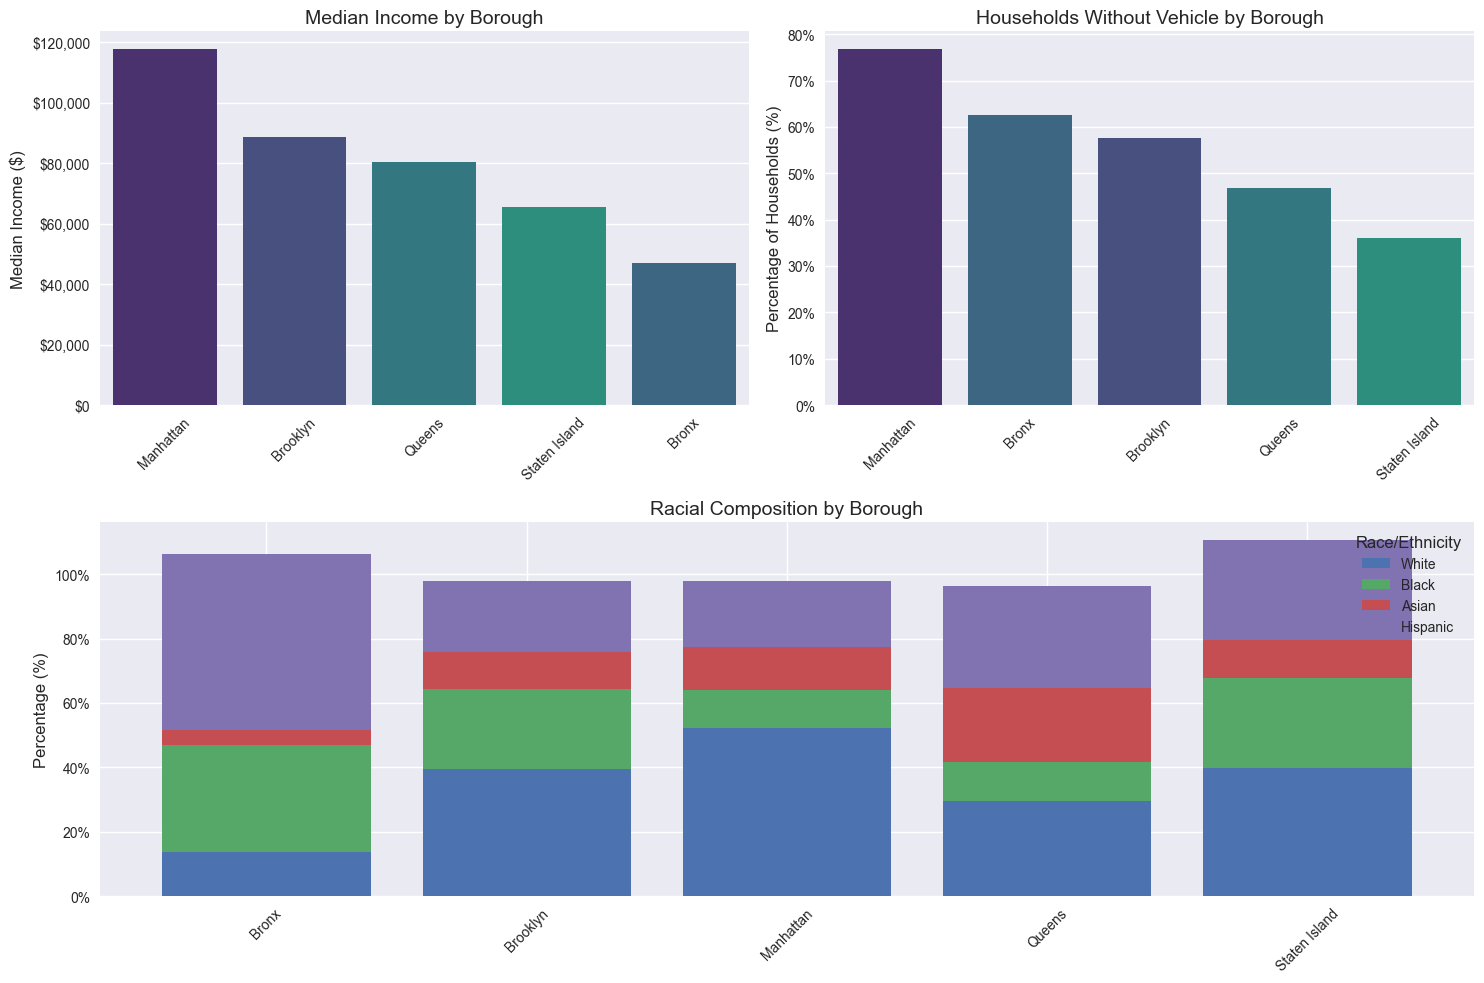

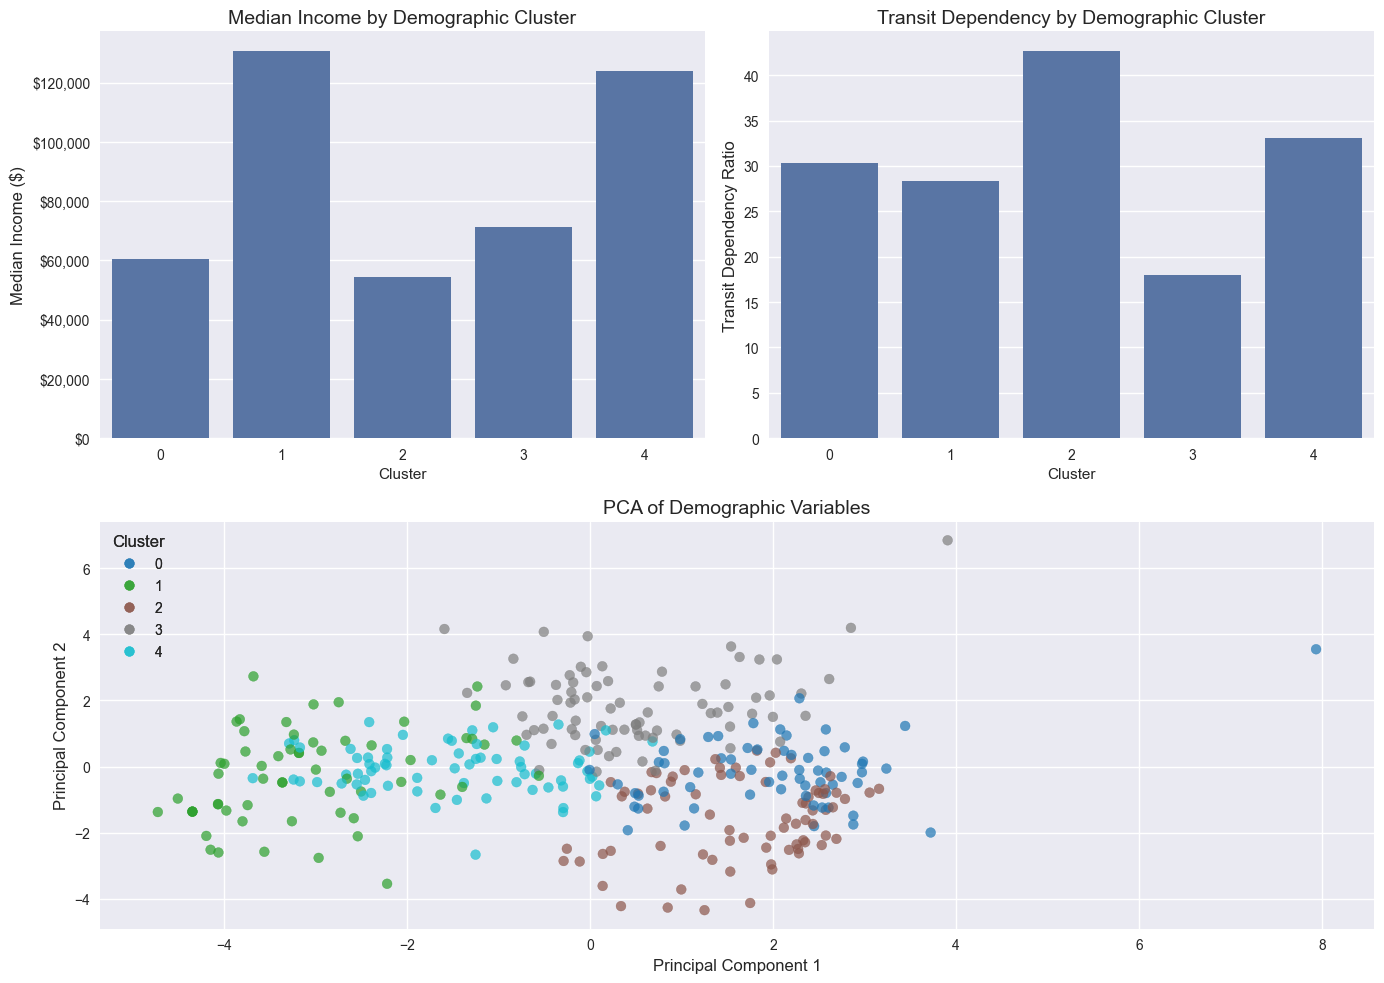


--- 2. Transit Reliability Visualizations ---


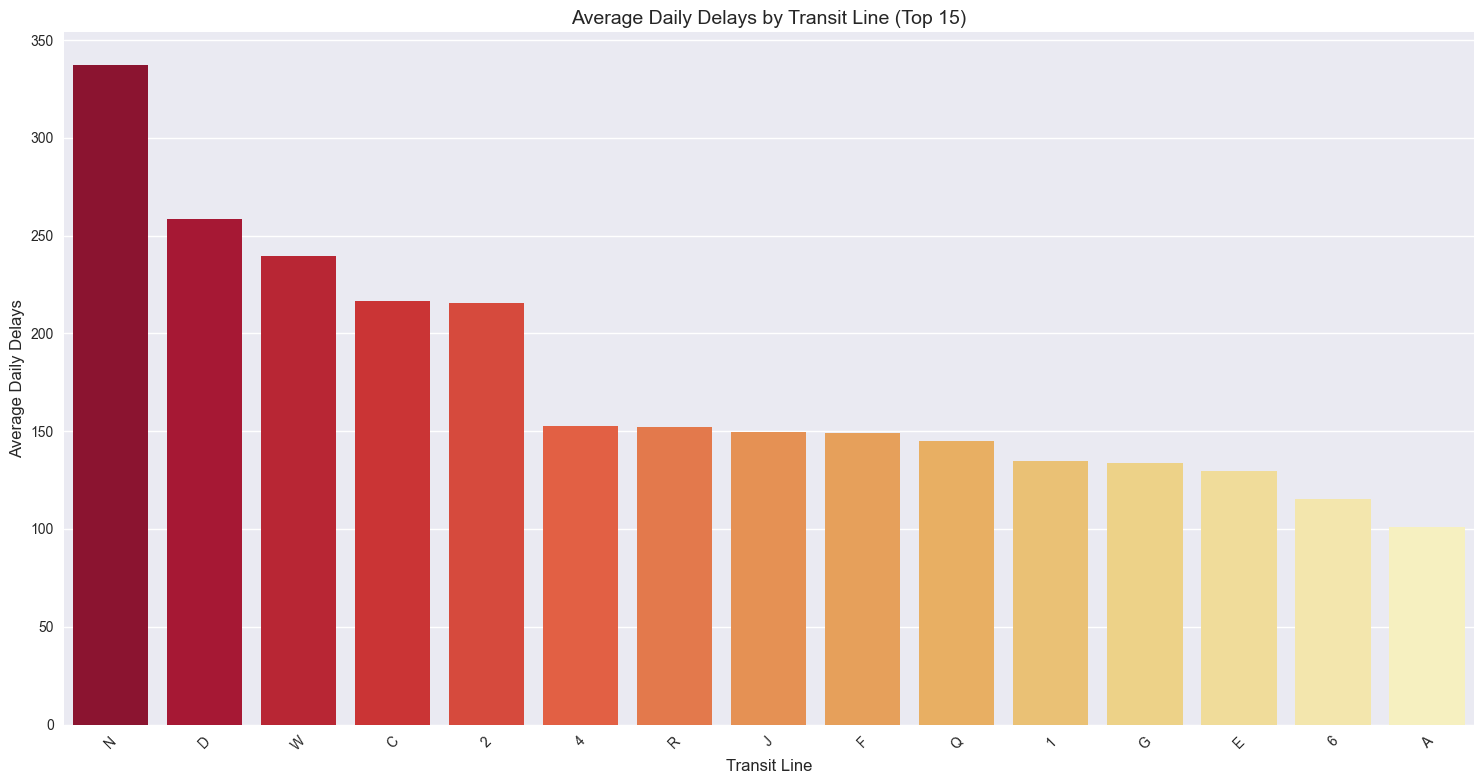

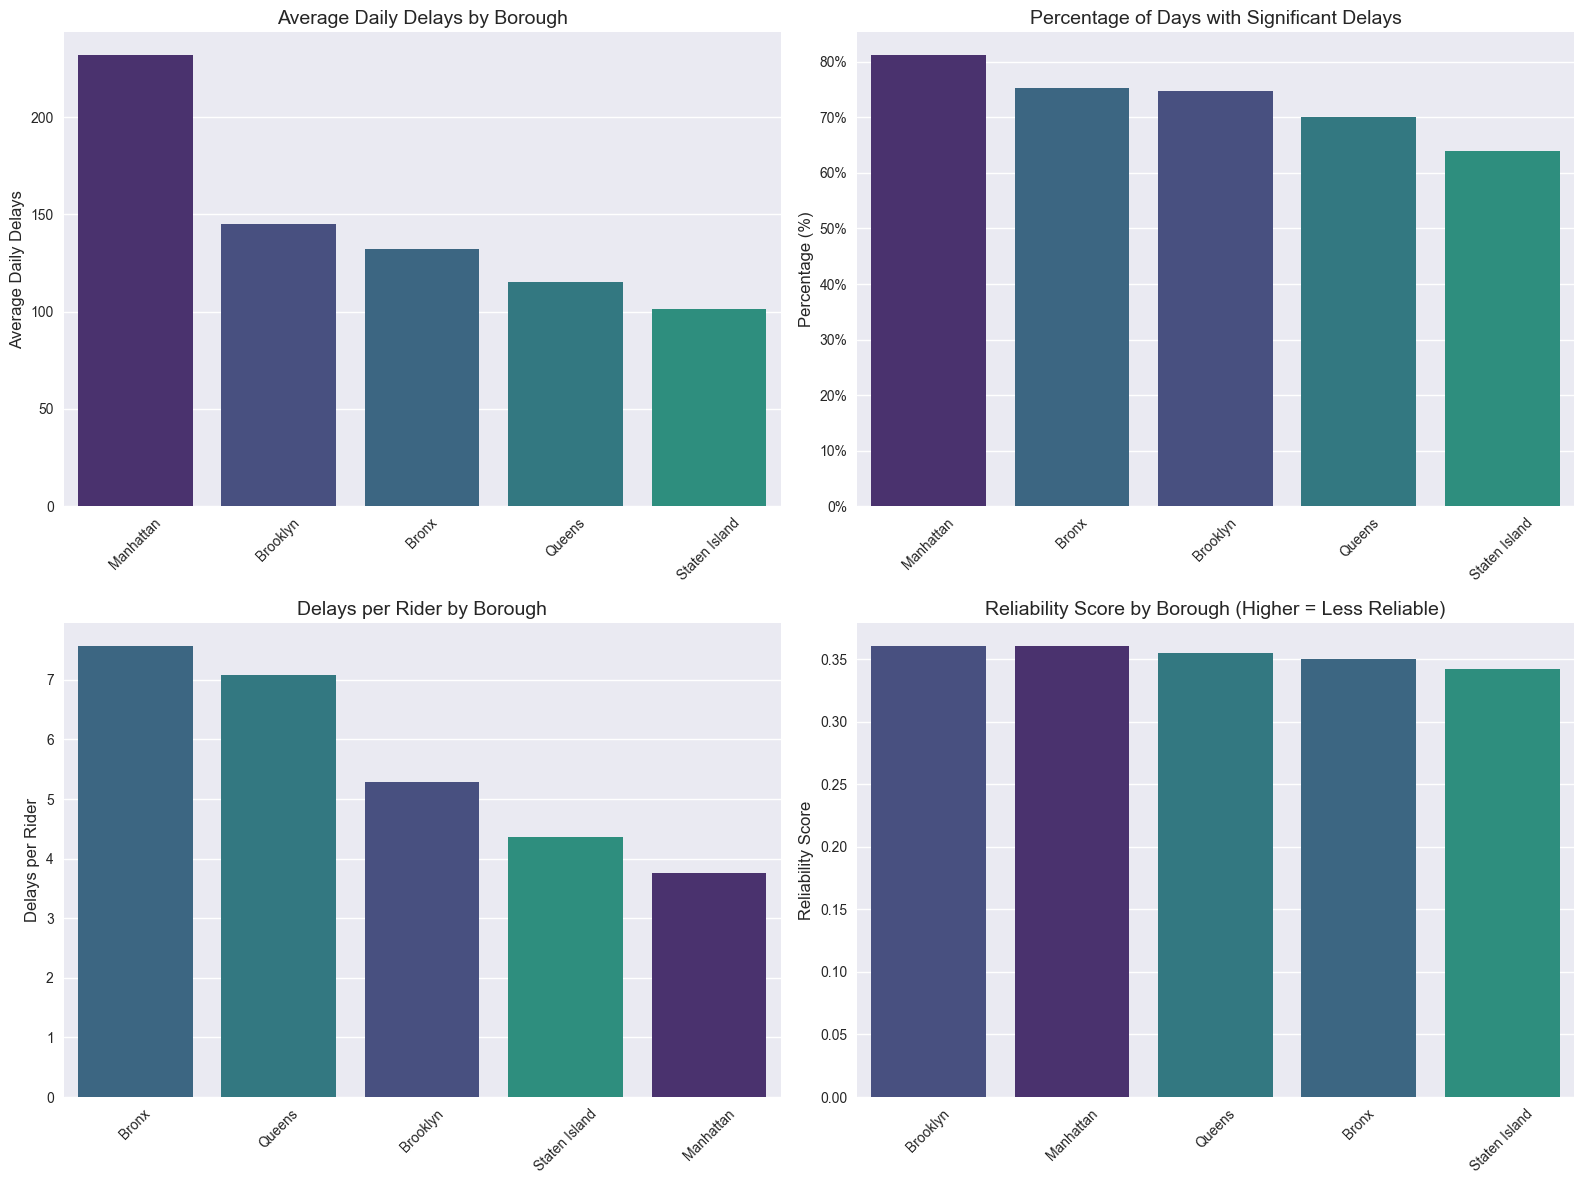

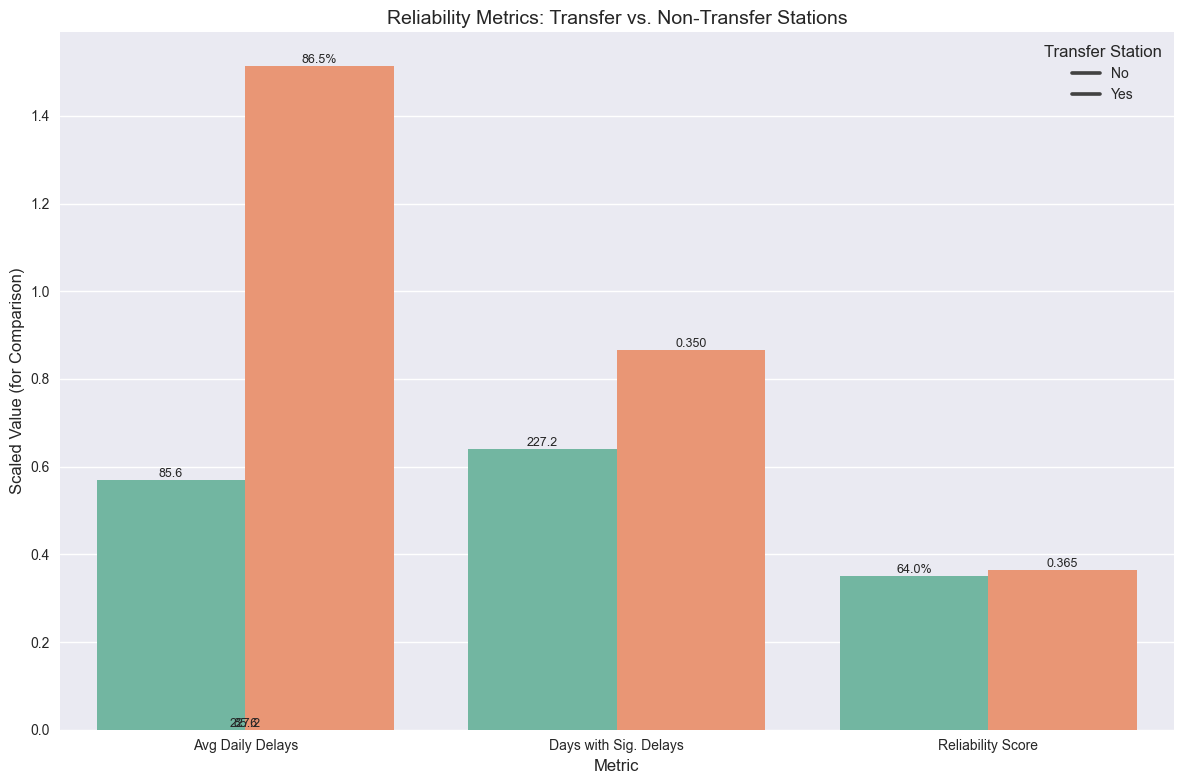


--- 3. Equity Impact Visualizations ---


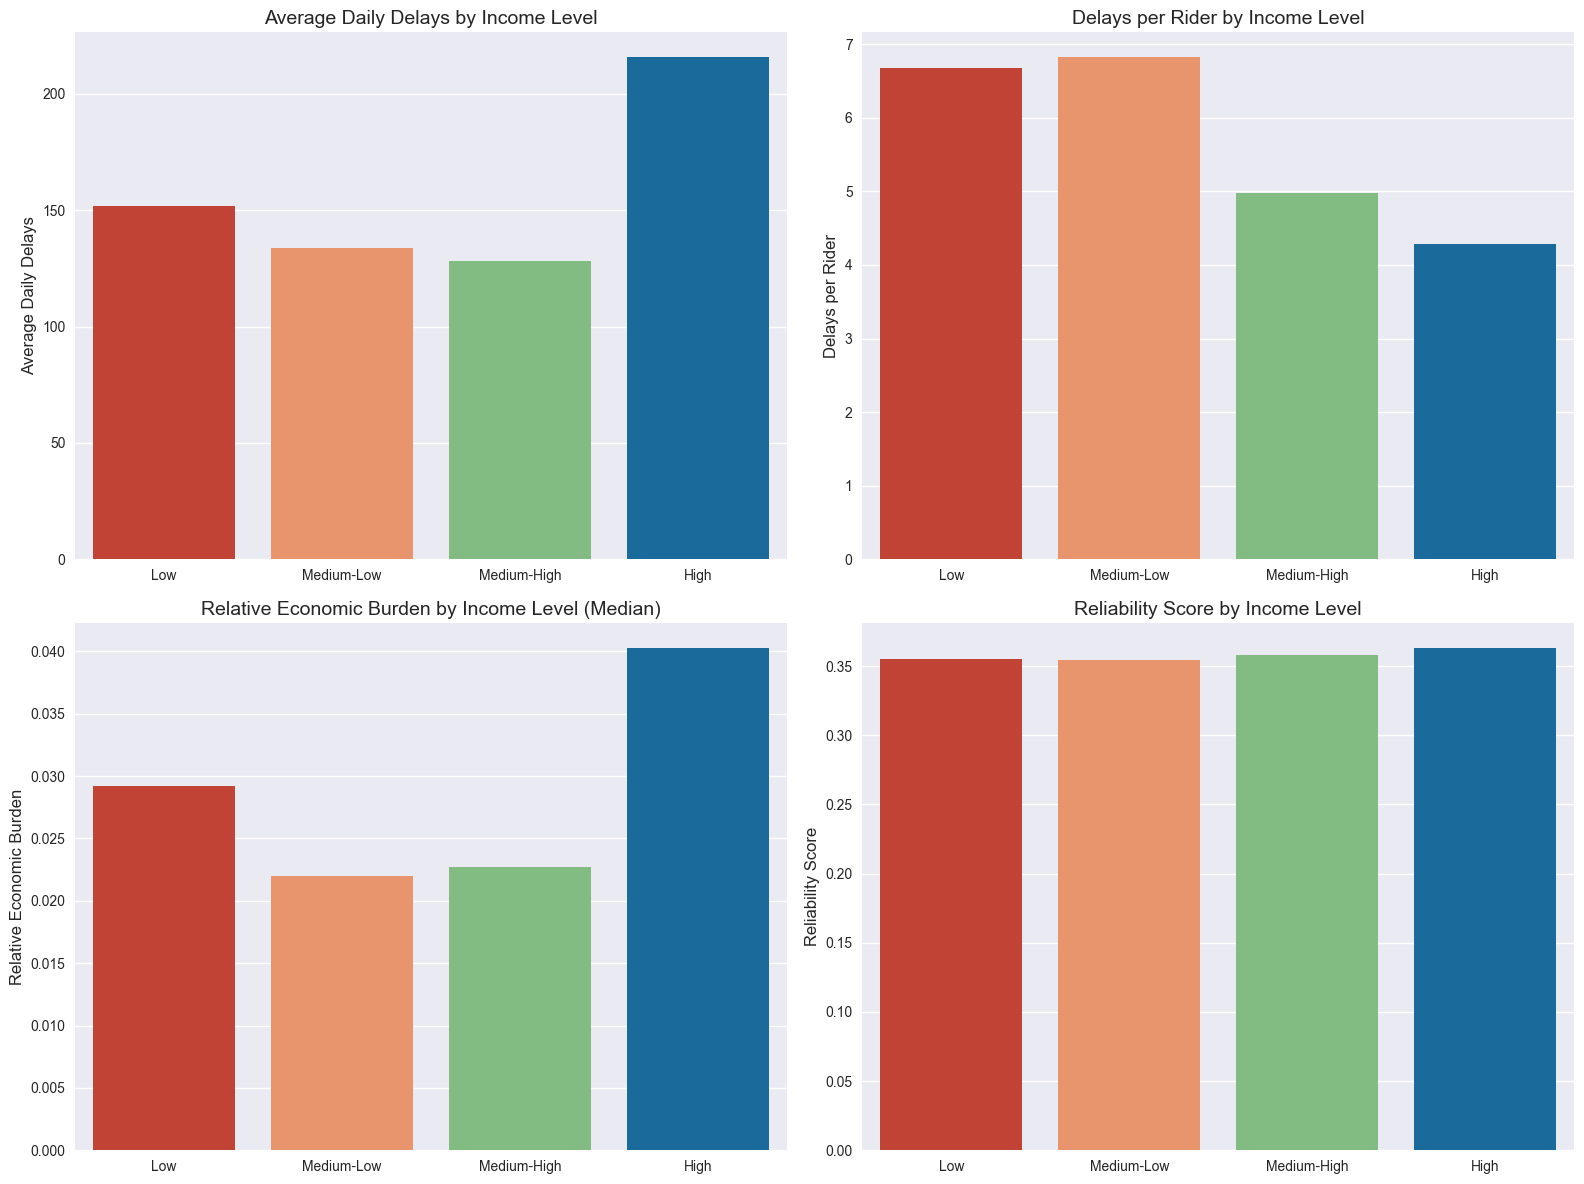

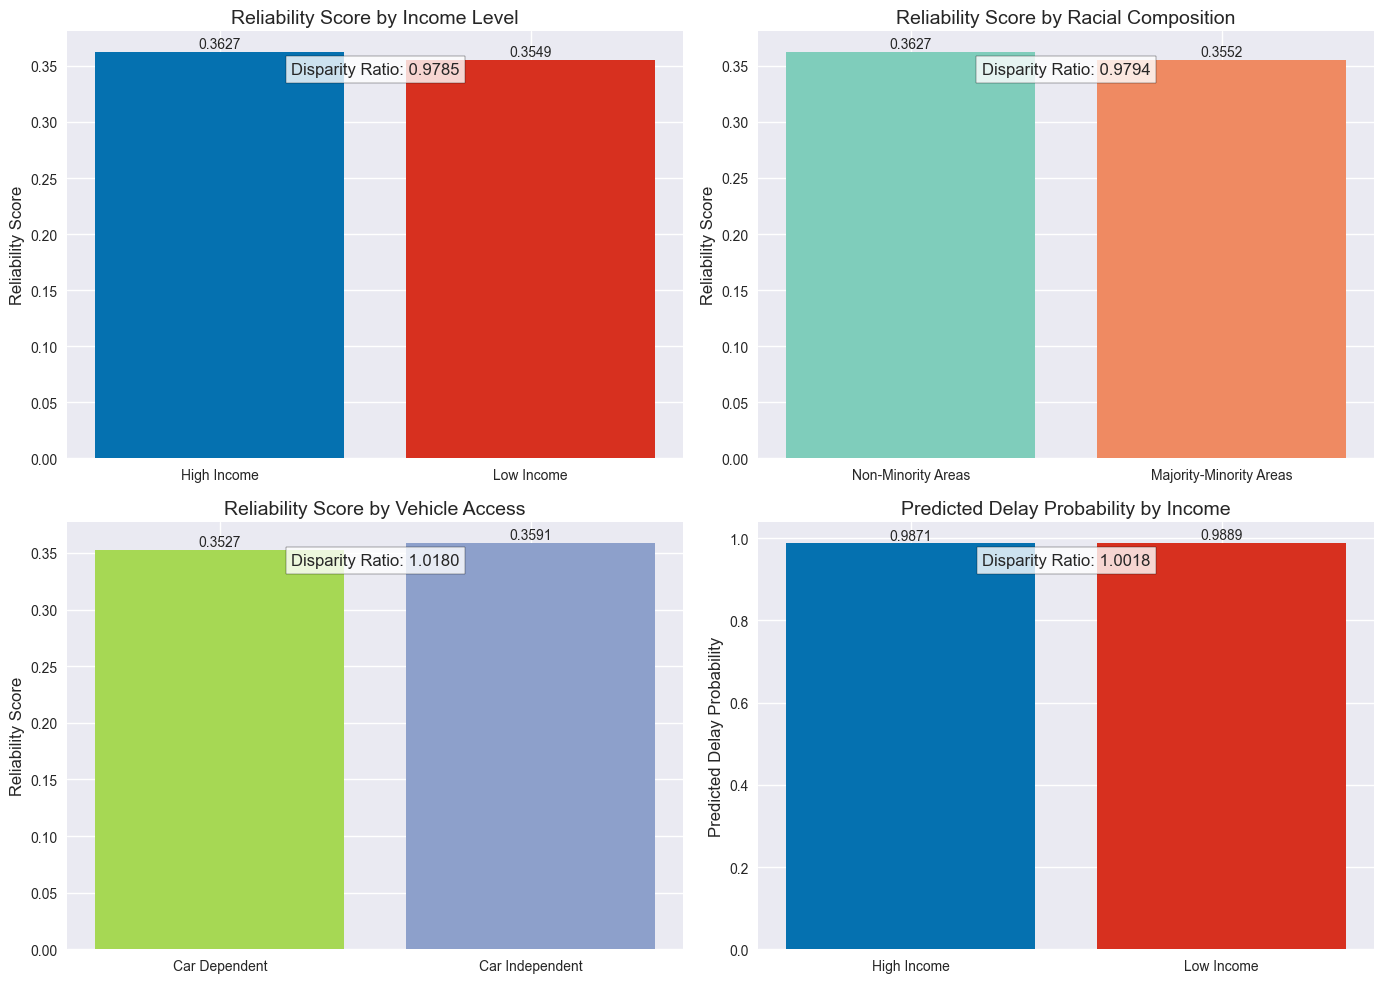

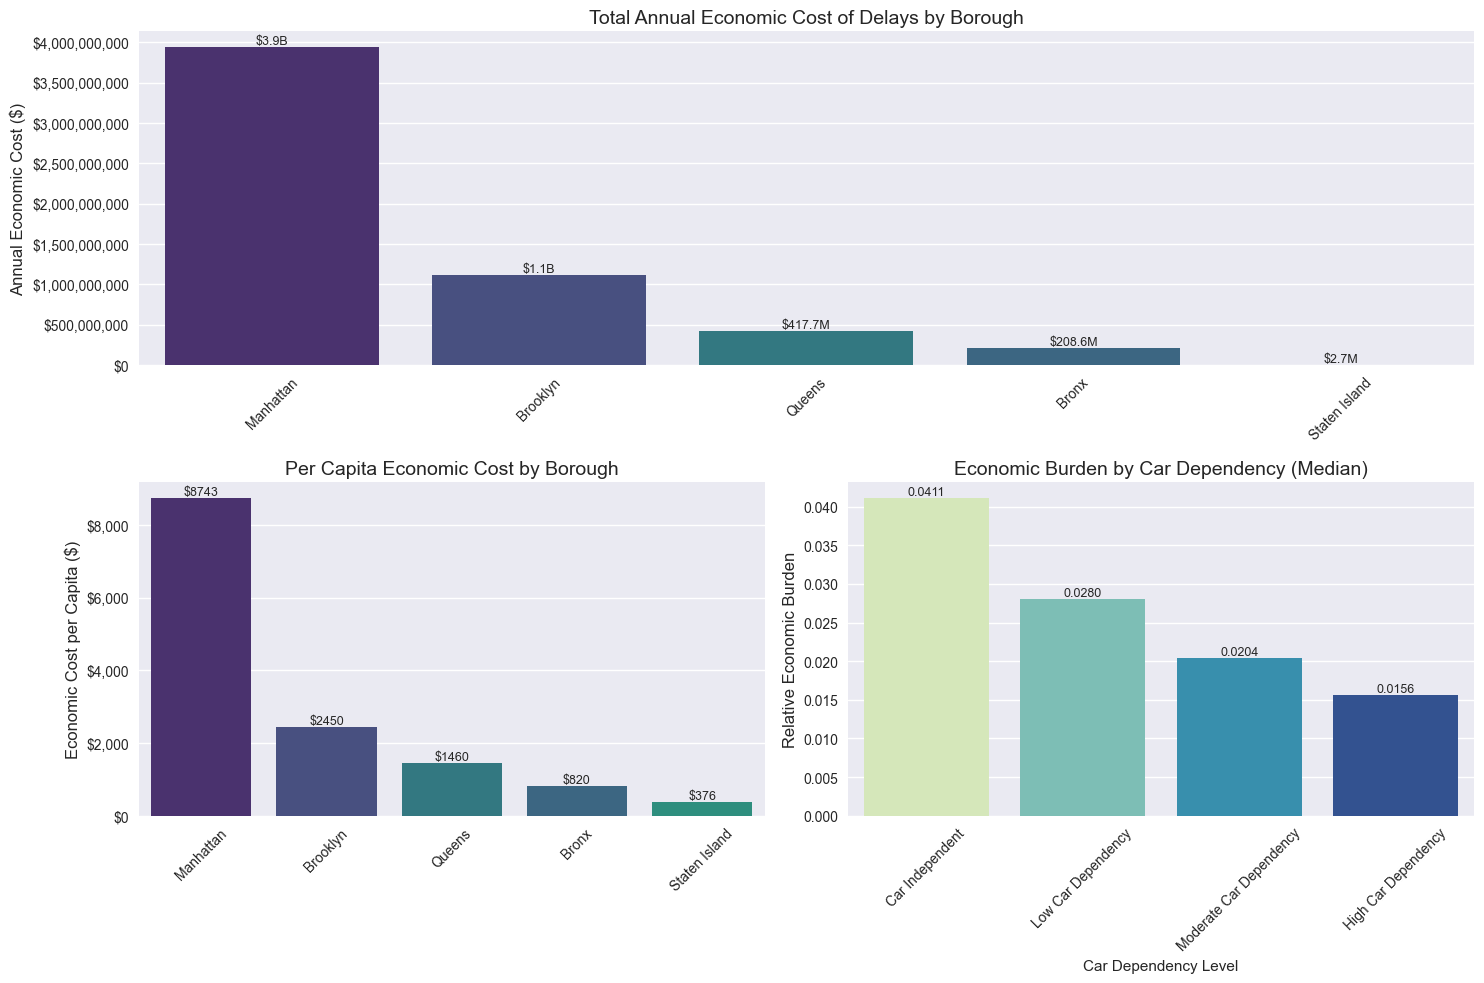


--- 4. Accessibility and Mobility Visualizations ---


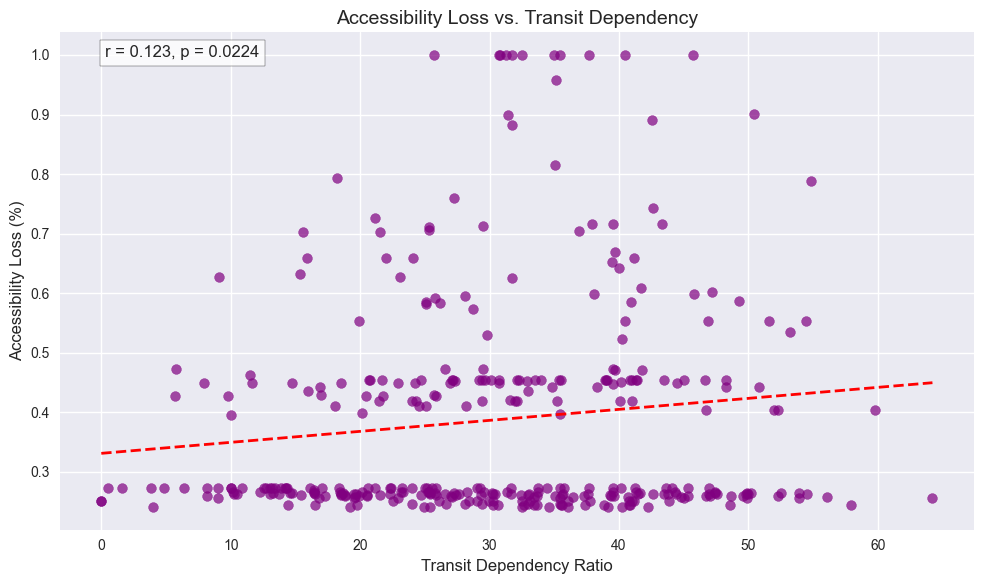


--- 5. Equity Priority Visualizations ---


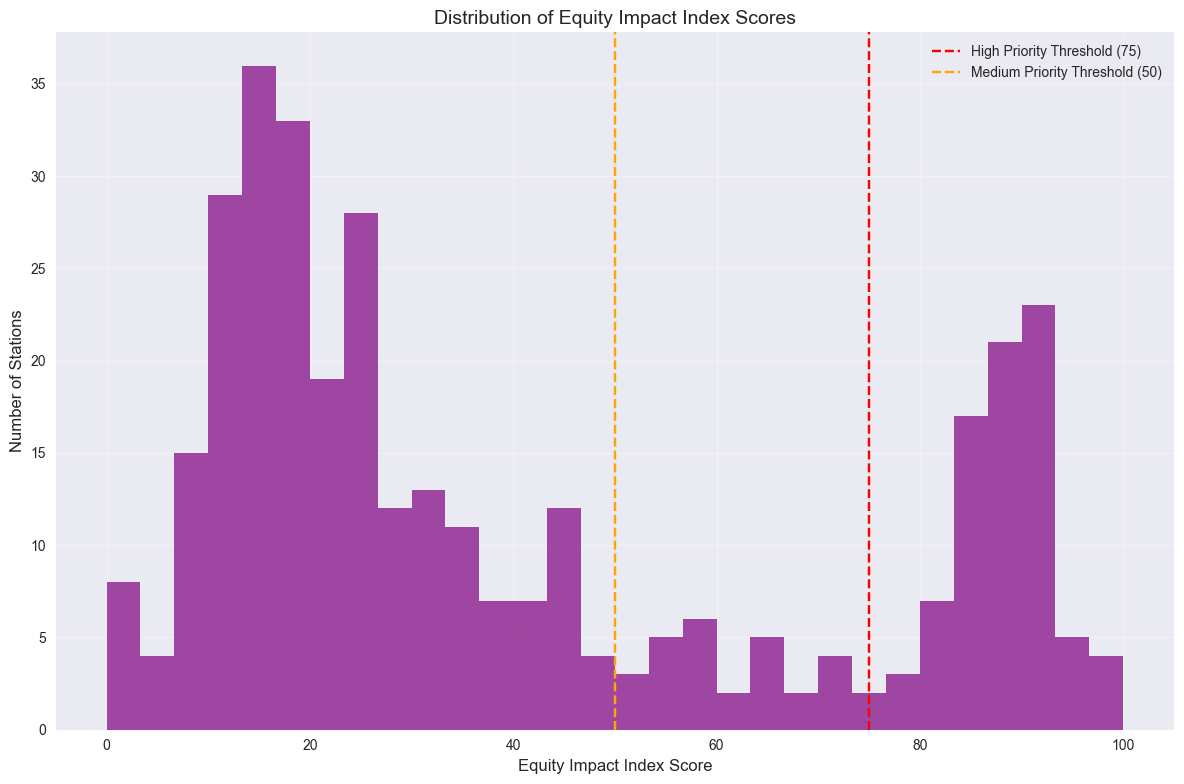

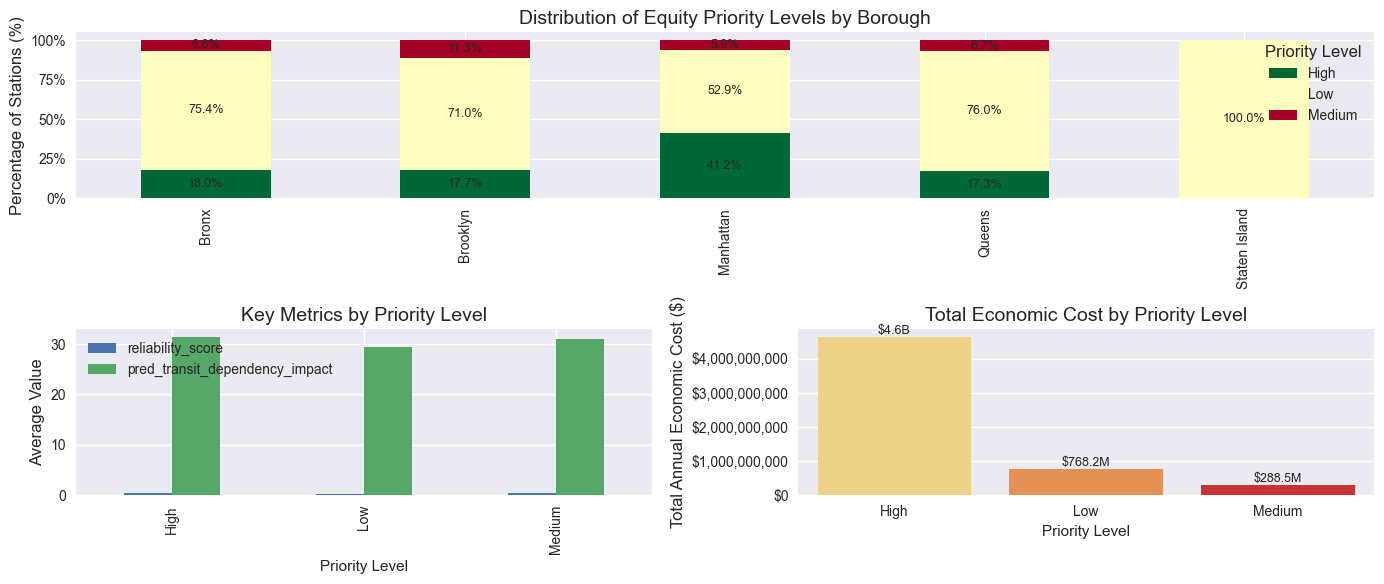

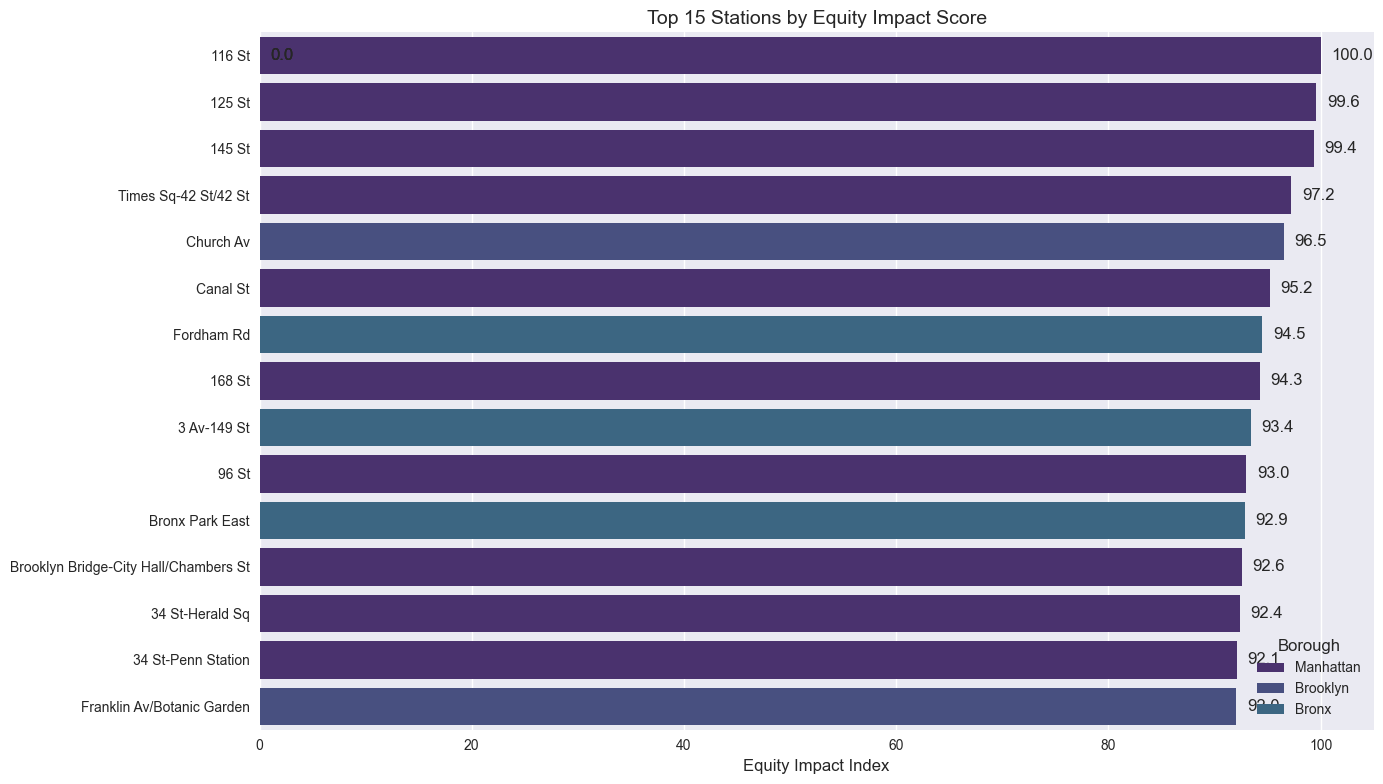


--- 6. Intervention Strategy Visualizations ---


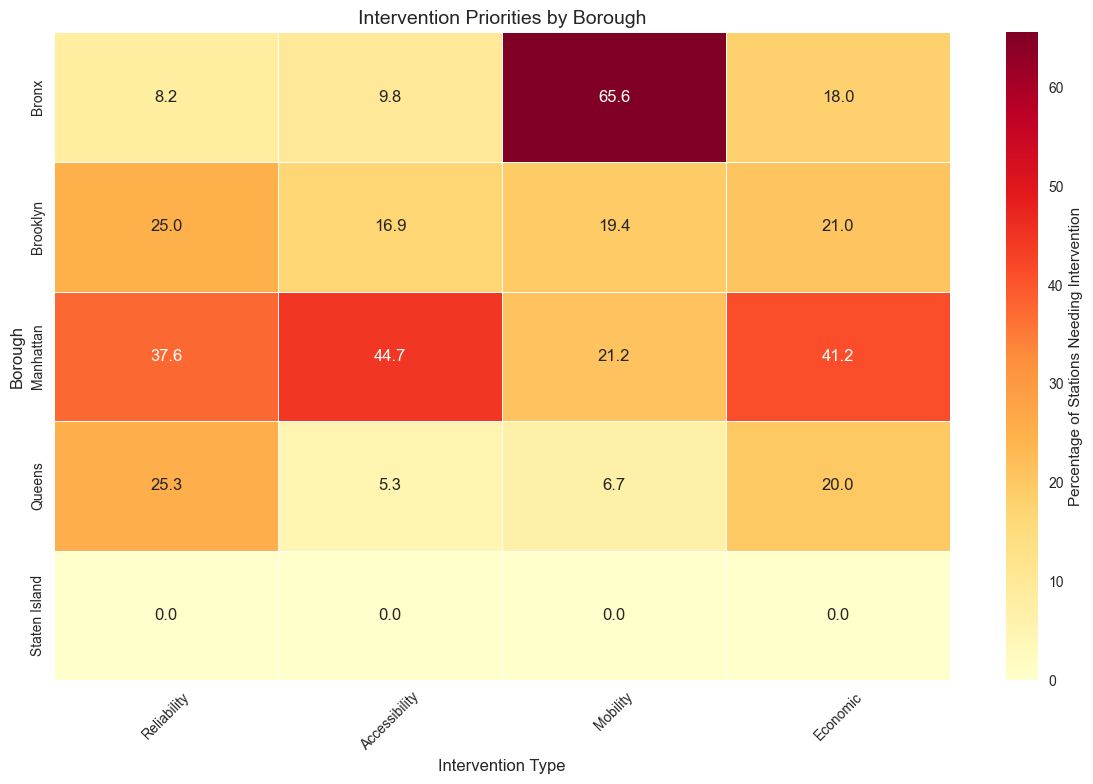

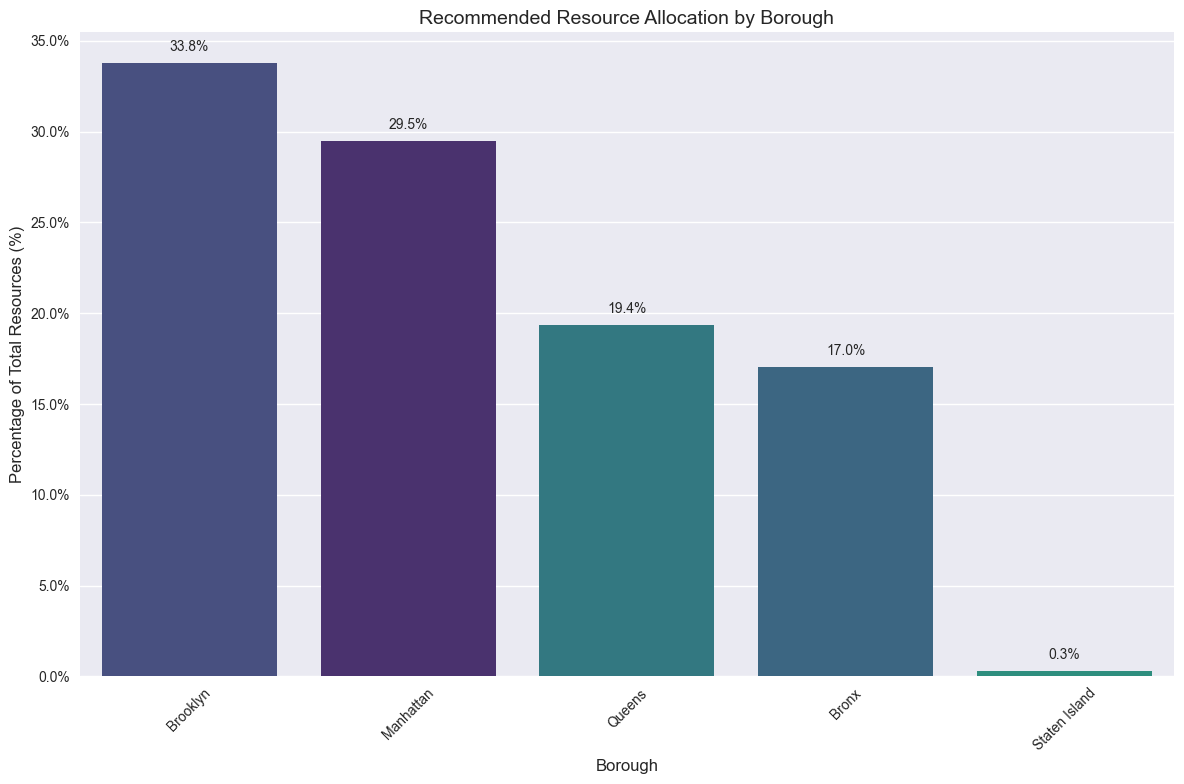

<Figure size 1200x800 with 0 Axes>

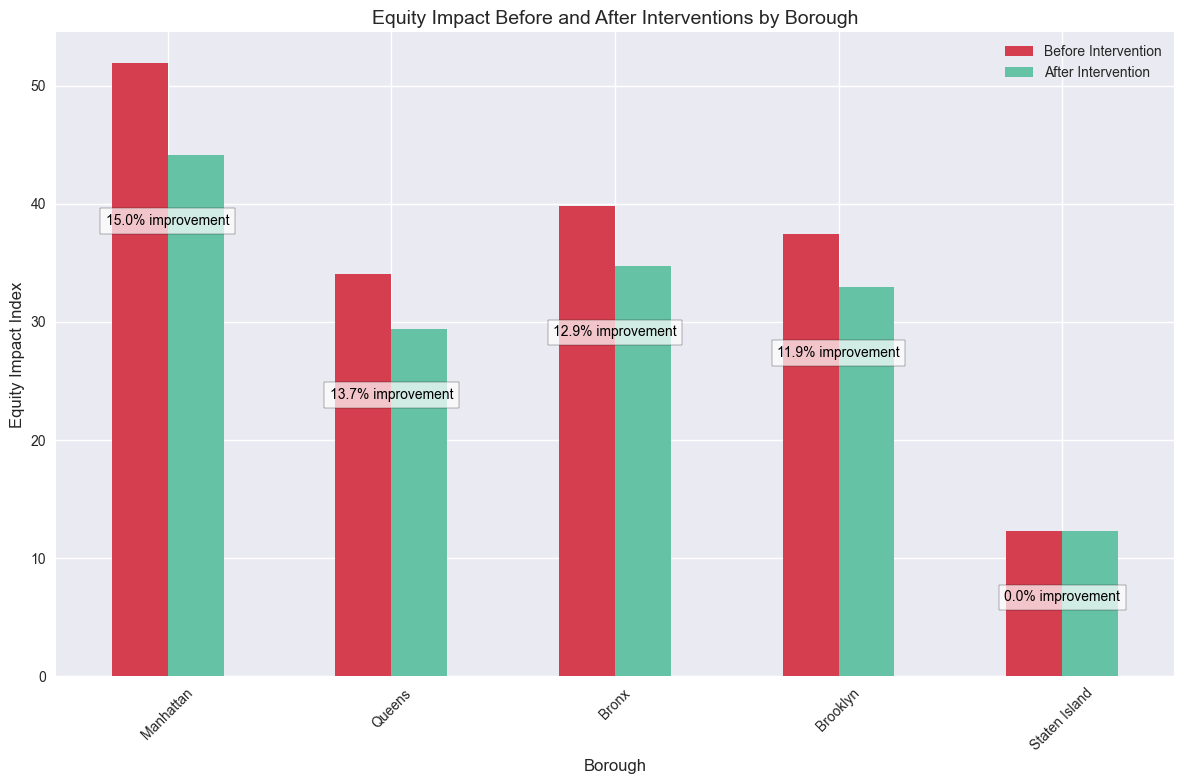

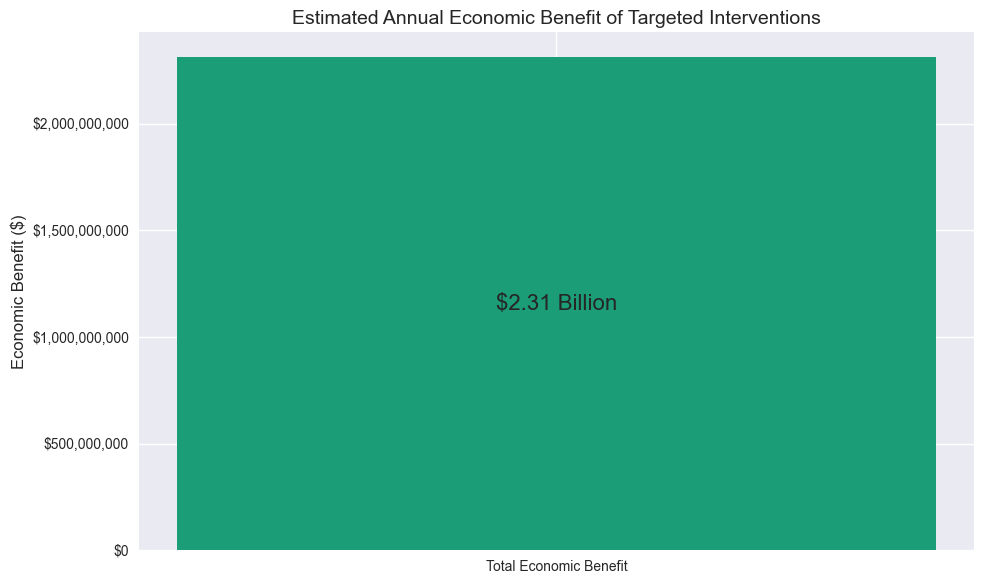


--- 7. Final Summary Visualizations ---


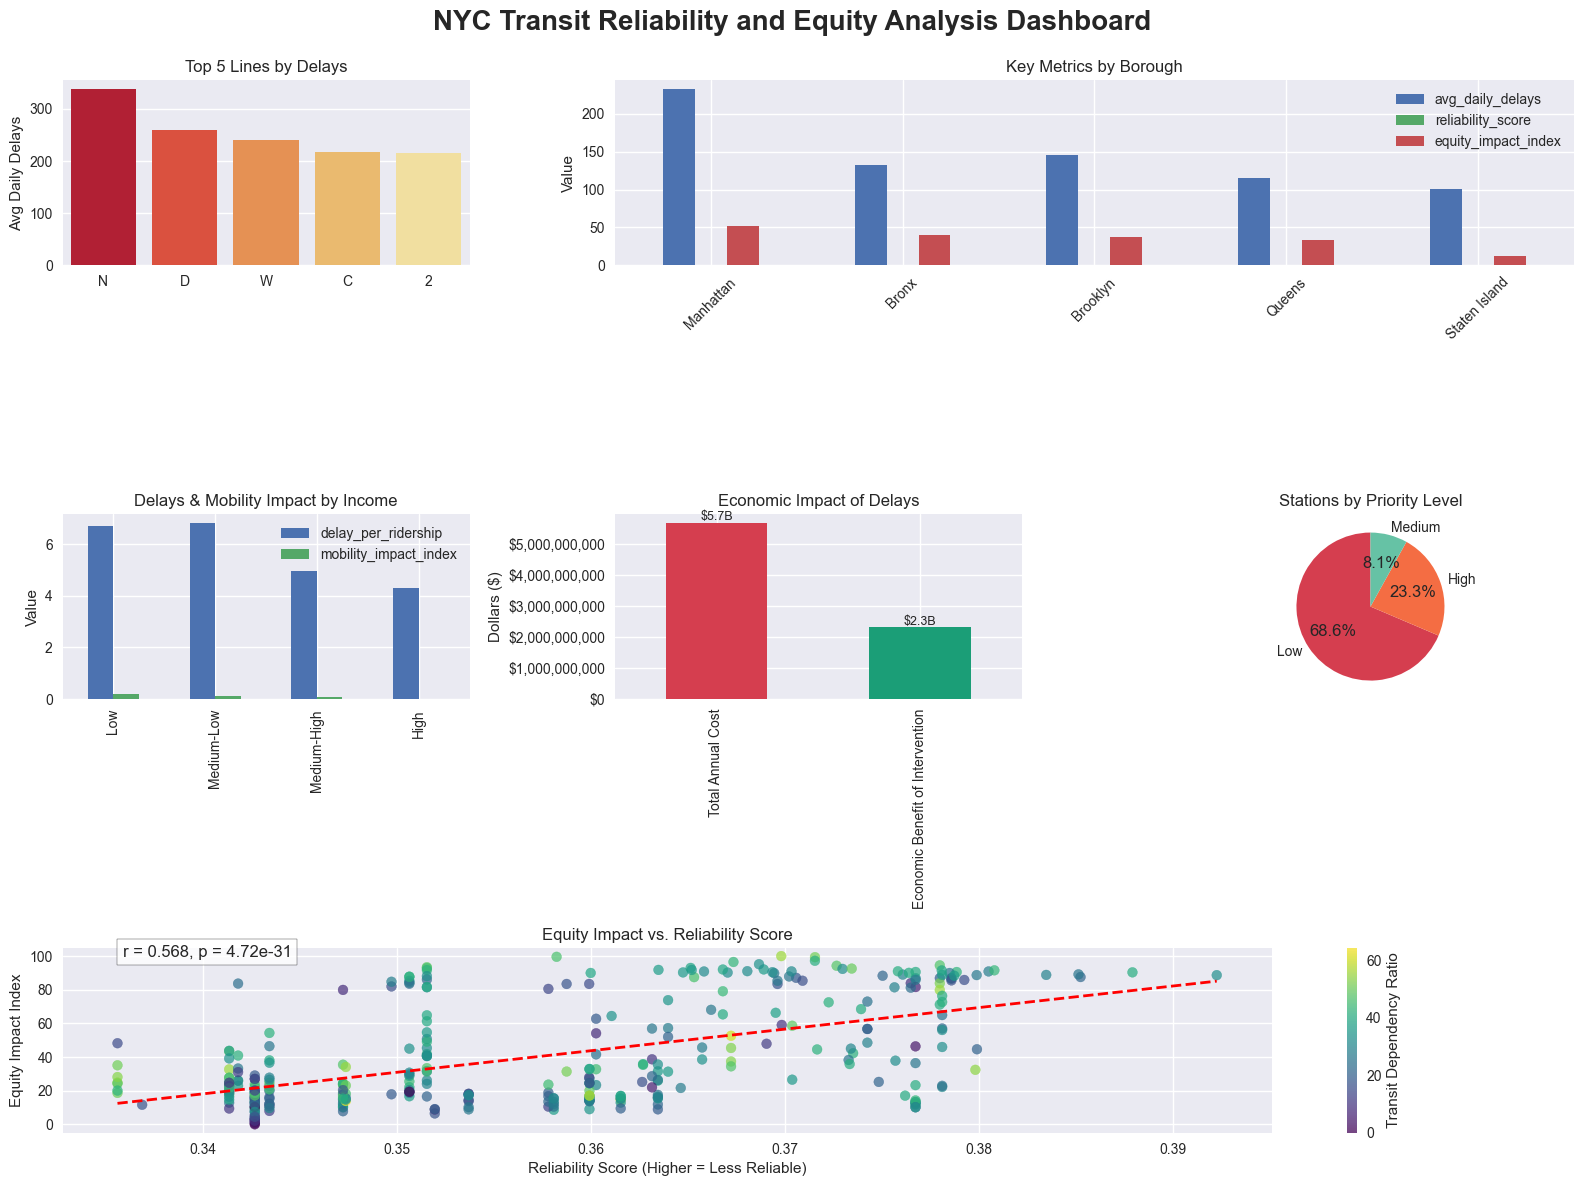


All visualizations completed successfully!


In [18]:
# Step 10: TRANSIT EQUITY ANALYSIS - VISUALIZATIONS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

print("=== 10.2 TRANSIT EQUITY ANALYSIS - VISUALIZATIONS ===")

# Load the results from the previous analysis
analysis_df = pd.read_csv('analysis_results.csv')
print(f"Loaded analysis results with {len(analysis_df)} stations")

# Set style for all visualizations
plt.style.use('seaborn')
colors = sns.color_palette("viridis", 8)
borough_colors = {
    'Manhattan': colors[0],
    'Brooklyn': colors[1],
    'Bronx': colors[2],
    'Queens': colors[3],
    'Staten Island': colors[4]
}

# Define color maps for different metrics
cmap_reliability = 'YlOrRd'      # Yellow to Red for reliability (higher = worse)
cmap_equity = 'RdPu'             # Red to Purple for equity impact
cmap_income = 'GnBu'             # Green to Blue for income
cmap_accessibility = 'YlGnBu'    # Yellow to Green to Blue for accessibility

# -----------------------------------------------
# 1. DEMOGRAPHIC VISUALIZATIONS
# -----------------------------------------------
print("\n--- 1. Demographic Visualizations ---")

# 1.1 Borough Demographics Comparison
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Income by Borough
ax1 = plt.subplot(gs[0, 0])
boroughs = analysis_df.groupby('borough_first')['median_income'].mean().sort_values(ascending=False)
sns.barplot(x=boroughs.index, y=boroughs.values, palette=[borough_colors[b] for b in boroughs.index], ax=ax1)
ax1.set_title('Median Income by Borough', fontsize=14)
ax1.set_ylabel('Median Income ($)', fontsize=12)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Car Dependency by Borough
ax2 = plt.subplot(gs[0, 1])
no_vehicle = analysis_df.groupby('borough_first')['pct_no_vehicle'].mean().sort_values(ascending=False)
sns.barplot(x=no_vehicle.index, y=no_vehicle.values, palette=[borough_colors[b] for b in no_vehicle.index], ax=ax2)
ax2.set_title('Households Without Vehicle by Borough', fontsize=14)
ax2.set_ylabel('Percentage of Households (%)', fontsize=12)
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(100))

# Racial Composition by Borough (stacked bar chart)
ax3 = plt.subplot(gs[1, :])
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']
race_labels = ['White', 'Black', 'Asian', 'Hispanic']
borough_race = analysis_df.groupby('borough_first')[race_columns].mean()

bottom = np.zeros(len(borough_race))
for i, col in enumerate(race_columns):
    ax3.bar(borough_race.index, borough_race[col], bottom=bottom, label=race_labels[i])
    bottom += borough_race[col].values

ax3.set_title('Racial Composition by Borough', fontsize=14)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax3.legend(title='Race/Ethnicity')

plt.tight_layout()
plt.savefig('demographic_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 1.2 Demographic Clusters Visualization
plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Income and Racial Distribution by Cluster
ax1 = plt.subplot(gs[0, 0])
cluster_income = analysis_df.groupby('demographic_cluster')['median_income'].mean().sort_values()
sns.barplot(x=cluster_income.index, y=cluster_income.values, ax=ax1)
ax1.set_title('Median Income by Demographic Cluster', fontsize=14)
ax1.set_ylabel('Median Income ($)', fontsize=12)
ax1.set_xlabel('Cluster')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Transit Dependency by Cluster
ax2 = plt.subplot(gs[0, 1])
cluster_transit = analysis_df.groupby('demographic_cluster')['transit_dependency_ratio'].mean().sort_values()
sns.barplot(x=cluster_transit.index, y=cluster_transit.values, ax=ax2)
ax2.set_title('Transit Dependency by Demographic Cluster', fontsize=14)
ax2.set_ylabel('Transit Dependency Ratio', fontsize=12)
ax2.set_xlabel('Cluster')

# PCA Visualization
ax3 = plt.subplot(gs[1, :])
scatter = ax3.scatter(
    analysis_df['demo_pc1'], 
    analysis_df['demo_pc2'],
    c=analysis_df['demographic_cluster'], 
    cmap='tab10',
    alpha=0.7,
    s=50
)
ax3.set_title('PCA of Demographic Variables', fontsize=14)
ax3.set_xlabel('Principal Component 1', fontsize=12)
ax3.set_ylabel('Principal Component 2', fontsize=12)
legend = ax3.legend(*scatter.legend_elements(), title="Cluster")
ax3.add_artist(legend)

plt.tight_layout()
plt.savefig('demographic_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 2. TRANSIT RELIABILITY VISUALIZATIONS
# -----------------------------------------------
print("\n--- 2. Transit Reliability Visualizations ---")

# 2.1 Delay statistics by transit line (Top 15)
plt.figure(figsize=(15, 8))
top_lines = analysis_df.groupby('primary_line')['avg_daily_delays'].mean().sort_values(ascending=False).head(15)
ax = sns.barplot(x=top_lines.index, y=top_lines.values, palette='YlOrRd_r')
ax.set_title('Average Daily Delays by Transit Line (Top 15)', fontsize=14)
ax.set_ylabel('Average Daily Delays', fontsize=12)
ax.set_xlabel('Transit Line', fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('line_delays.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2.2 Reliability metrics by borough
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=plt.gcf())

# Average Daily Delays by Borough
ax1 = plt.subplot(gs[0, 0])
borough_delays = analysis_df.groupby('borough_first')['avg_daily_delays'].mean().sort_values(ascending=False)
sns.barplot(x=borough_delays.index, y=borough_delays.values, 
            palette=[borough_colors[b] for b in borough_delays.index], ax=ax1)
ax1.set_title('Average Daily Delays by Borough', fontsize=14)
ax1.set_ylabel('Average Daily Delays', fontsize=12)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)

# Delay Frequency by Borough
ax2 = plt.subplot(gs[0, 1])
borough_frequency = analysis_df.groupby('borough_first')['pct_days_with_significant_delay'].mean().sort_values(ascending=False)
sns.barplot(x=borough_frequency.index, y=borough_frequency.values, 
            palette=[borough_colors[b] for b in borough_frequency.index], ax=ax2)
ax2.set_title('Percentage of Days with Significant Delays', fontsize=14)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Delay per Ridership by Borough
ax3 = plt.subplot(gs[1, 0])
borough_per_rider = analysis_df.groupby('borough_first')['delay_per_ridership'].mean().sort_values(ascending=False)
sns.barplot(x=borough_per_rider.index, y=borough_per_rider.values, 
            palette=[borough_colors[b] for b in borough_per_rider.index], ax=ax3)
ax3.set_title('Delays per Rider by Borough', fontsize=14)
ax3.set_ylabel('Delays per Rider', fontsize=12)
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)

# Reliability Score by Borough
ax4 = plt.subplot(gs[1, 1])
borough_reliability = analysis_df.groupby('borough_first')['reliability_score'].mean().sort_values(ascending=False)
sns.barplot(x=borough_reliability.index, y=borough_reliability.values, 
            palette=[borough_colors[b] for b in borough_reliability.index], ax=ax4)
ax4.set_title('Reliability Score by Borough (Higher = Less Reliable)', fontsize=14)
ax4.set_ylabel('Reliability Score', fontsize=12)
ax4.set_xlabel('')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('borough_reliability.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2.3 Transfer vs. Non-Transfer Station Reliability
plt.figure(figsize=(12, 8))
transfer_reliability = analysis_df.groupby('is_transfer_station')[
    ['avg_daily_delays', 'pct_days_with_significant_delay', 'reliability_score']
].mean().reset_index()

# Melt for easier plotting
transfer_melt = pd.melt(
    transfer_reliability, 
    id_vars=['is_transfer_station'],
    value_vars=['avg_daily_delays', 'pct_days_with_significant_delay', 'reliability_score'],
    var_name='Metric', 
    value_name='Value'
)

# Add scaling for comparable plotting
transfer_melt['Scaled_Value'] = transfer_melt.apply(
    lambda x: x['Value'] if x['Metric'] == 'reliability_score' else
              x['Value']/150 if x['Metric'] == 'avg_daily_delays' else
              x['Value'],
    axis=1
)

ax = sns.barplot(
    x='Metric', 
    y='Scaled_Value', 
    hue='is_transfer_station',
    palette=['#66c2a5', '#fc8d62'],
    data=transfer_melt
)

# Annotate bars with original values
patch_to_data = {}
for i, patch in enumerate(ax.patches):
    data_idx = i % len(transfer_melt)
    patch_to_data[patch] = transfer_melt.iloc[data_idx]

for p in ax.patches:
    data_row = patch_to_data[p]
    metric = data_row['Metric']
    value = data_row['Value']
    if metric == 'pct_days_with_significant_delay':
        value_text = f"{value:.1%}"
    elif metric == 'avg_daily_delays':
        value_text = f"{value:.1f}"
    else:
        value_text = f"{value:.3f}"
    ax.annotate(
        value_text, 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=9
    )

ax.set_title('Reliability Metrics: Transfer vs. Non-Transfer Stations', fontsize=14)
ax.set_ylabel('Scaled Value (for Comparison)', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.legend(title='Transfer Station', labels=['No', 'Yes'])
plt.xticks(
    ticks=range(3),
    labels=['Avg Daily Delays', 'Days with Sig. Delays', 'Reliability Score'],
    rotation=0
)
plt.tight_layout()
plt.savefig('transfer_reliability.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 3. EQUITY IMPACT VISUALIZATIONS
# -----------------------------------------------
print("\n--- 3. Equity Impact Visualizations ---")

# 3.1 Delay metrics by income group
plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=plt.gcf())

# Color palette for income categories
income_colors = {'Low': '#d7301f', 'Medium-Low': '#fc8d59', 
                 'Medium-High': '#78c679', 'High': '#0571b0'}

# Convert income categories to ordered categories
if 'income_category' in analysis_df.columns:
    income_order = ['Low', 'Medium-Low', 'Medium-High', 'High']
    analysis_df['income_category_ordered'] = pd.Categorical(
        analysis_df['income_category'], 
        categories=income_order, 
        ordered=True
    )

    # Average Daily Delays by Income
    ax1 = plt.subplot(gs[0, 0])
    income_delays = analysis_df.groupby('income_category_ordered')['avg_daily_delays'].mean()
    sns.barplot(x=income_delays.index, y=income_delays.values, 
                palette=[income_colors[inc] for inc in income_delays.index], ax=ax1)
    ax1.set_title('Average Daily Delays by Income Level', fontsize=14)
    ax1.set_ylabel('Average Daily Delays', fontsize=12)
    ax1.set_xlabel('')

    # Delay per Ridership by Income
    ax2 = plt.subplot(gs[0, 1])
    income_per_rider = analysis_df.groupby('income_category_ordered')['delay_per_ridership'].mean()
    sns.barplot(x=income_per_rider.index, y=income_per_rider.values, 
                palette=[income_colors[inc] for inc in income_per_rider.index], ax=ax2)
    ax2.set_title('Delays per Rider by Income Level', fontsize=14)
    ax2.set_ylabel('Delays per Rider', fontsize=12)
    ax2.set_xlabel('')

    # Economic Burden by Income (using median to avoid inf values)
    ax3 = plt.subplot(gs[1, 0])
    income_burden = analysis_df.groupby('income_category_ordered')['relative_econ_burden'].median()
    sns.barplot(x=income_burden.index, y=income_burden.values, 
                palette=[income_colors[inc] for inc in income_burden.index], ax=ax3)
    ax3.set_title('Relative Economic Burden by Income Level (Median)', fontsize=14)
    ax3.set_ylabel('Relative Economic Burden', fontsize=12)
    ax3.set_xlabel('')
    
    # Reliability Score by Income
    ax4 = plt.subplot(gs[1, 1])
    income_reliability = analysis_df.groupby('income_category_ordered')['reliability_score'].mean()
    sns.barplot(x=income_reliability.index, y=income_reliability.values, 
                palette=[income_colors[inc] for inc in income_reliability.index], ax=ax4)
    ax4.set_title('Reliability Score by Income Level', fontsize=14)
    ax4.set_ylabel('Reliability Score', fontsize=12)
    ax4.set_xlabel('')

    plt.tight_layout()
    plt.savefig('income_equity.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 3.2 Disparate Impact Analysis
plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Income-Based Disparate Impact
ax1 = plt.subplot(gs[0, 0])
if 'income_category' in analysis_df.columns:
    low_income_delay = analysis_df[analysis_df['income_category'] == 'Low']['reliability_score'].mean()
    high_income_delay = analysis_df[analysis_df['income_category'] == 'High']['reliability_score'].mean()
    
    income_bars = ax1.bar(['High Income', 'Low Income'], [high_income_delay, low_income_delay], 
                           color=['#0571b0', '#d7301f'])
    
    income_ratio = low_income_delay / high_income_delay if high_income_delay > 0 else 0
    ax1.text(0.5, 0.9, f'Disparity Ratio: {income_ratio:.4f}', 
             transform=ax1.transAxes, ha='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    ax1.set_title('Reliability Score by Income Level', fontsize=14)
    ax1.set_ylabel('Reliability Score', fontsize=12)
    
    for bar in income_bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Racial Disparate Impact
ax2 = plt.subplot(gs[0, 1])
if 'majority_minority' in analysis_df.columns:
    minority_delay = analysis_df[analysis_df['majority_minority'] == True]['reliability_score'].mean()
    non_minority_delay = analysis_df[analysis_df['majority_minority'] == False]['reliability_score'].mean()
    
    race_bars = ax2.bar(['Non-Minority Areas', 'Majority-Minority Areas'], 
                        [non_minority_delay, minority_delay], 
                        color=['#7fcdbb', '#ef8a62'])
    
    race_ratio = minority_delay / non_minority_delay if non_minority_delay > 0 else 0
    ax2.text(0.5, 0.9, f'Disparity Ratio: {race_ratio:.4f}', 
             transform=ax2.transAxes, ha='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    ax2.set_title('Reliability Score by Racial Composition', fontsize=14)
    ax2.set_ylabel('Reliability Score', fontsize=12)
    
    for bar in race_bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Vehicle Access Disparate Impact
ax3 = plt.subplot(gs[1, 0])
if 'car_dependency' in analysis_df.columns:
    car_dependent_categories = ['Car Independent', 'Low Car Dependency']
    if any(cat in analysis_df['car_dependency'].unique() for cat in car_dependent_categories):
        car_independent_mask = analysis_df['car_dependency'].isin(car_dependent_categories)
        car_independent_delay = analysis_df[car_independent_mask]['reliability_score'].mean()
        car_dependent_delay = analysis_df[~car_independent_mask]['reliability_score'].mean()
        
        vehicle_bars = ax3.bar(['Car Dependent', 'Car Independent'], 
                               [car_dependent_delay, car_independent_delay], 
                               color=['#a6d854', '#8da0cb'])
        
        vehicle_ratio = car_independent_delay / car_dependent_delay if car_dependent_delay > 0 else 0
        ax3.text(0.5, 0.9, f'Disparity Ratio: {vehicle_ratio:.4f}', 
                 transform=ax3.transAxes, ha='center', fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        ax3.set_title('Reliability Score by Vehicle Access', fontsize=14)
        ax3.set_ylabel('Reliability Score', fontsize=12)
        
        for bar in vehicle_bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                     f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Predicted Disparate Impact
ax4 = plt.subplot(gs[1, 1])
if 'income_category' in analysis_df.columns:
    low_income_pred = analysis_df[analysis_df['income_category'] == 'Low']['predicted_delay_probability'].mean()
    high_income_pred = analysis_df[analysis_df['income_category'] == 'High']['predicted_delay_probability'].mean()
    
    pred_bars = ax4.bar(['High Income', 'Low Income'], [high_income_pred, low_income_pred], 
                        color=['#0571b0', '#d7301f'])
    
    pred_ratio = low_income_pred / high_income_pred if high_income_pred > 0 else 0
    ax4.text(0.5, 0.9, f'Disparity Ratio: {pred_ratio:.4f}', 
             transform=ax4.transAxes, ha='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    ax4.set_title('Predicted Delay Probability by Income', fontsize=14)
    ax4.set_ylabel('Predicted Delay Probability', fontsize=12)
    
    for bar in pred_bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('disparate_impact.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 3.3 Economic Impact Visualization
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Economic Impact by Borough
ax1 = plt.subplot(gs[0, :])
borough_cost = analysis_df.groupby('borough_first')['annual_econ_cost'].sum().sort_values(ascending=False)
borough_bars = sns.barplot(x=borough_cost.index, y=borough_cost.values, 
                           palette=[borough_colors[b] for b in borough_cost.index], ax=ax1)
ax1.set_title('Total Annual Economic Cost of Delays by Borough', fontsize=14)
ax1.set_ylabel('Annual Economic Cost ($)', fontsize=12)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

for p in borough_bars.patches:
    height = p.get_height()
    if height >= 1e9:
        label = f'${height/1e9:.1f}B'
    elif height >= 1e6:
        label = f'${height/1e6:.1f}M'
    else:
        label = f'${height/1e3:.1f}K'
    borough_bars.annotate(label, (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='bottom', fontsize=9)

# Per Capita Cost by Borough
ax2 = plt.subplot(gs[1, 0])
borough_per_capita = analysis_df.groupby('borough_first').apply(
    lambda x: x['annual_econ_cost'].sum() / x['total_population'].sum() if x['total_population'].sum() > 0 else 0
).sort_values(ascending=False)
per_capita_bars = sns.barplot(x=borough_per_capita.index, y=borough_per_capita.values, 
                              palette=[borough_colors[b] for b in borough_per_capita.index], ax=ax2)
ax2.set_title('Per Capita Economic Cost by Borough', fontsize=14)
ax2.set_ylabel('Economic Cost per Capita ($)', fontsize=12)
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
for p in per_capita_bars.patches:
    per_capita_bars.annotate(f'${p.get_height():.0f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', fontsize=9)

# Economic Burden by Car Dependency
ax3 = plt.subplot(gs[1, 1])
if 'car_dependency' in analysis_df.columns:
    car_burden = analysis_df.groupby('car_dependency')['relative_econ_burden'].median().sort_values(ascending=False)
    burden_bars = sns.barplot(x=car_burden.index, y=car_burden.values, palette='YlGnBu', ax=ax3)
    ax3.set_title('Economic Burden by Car Dependency (Median)', fontsize=14)
    ax3.set_ylabel('Relative Economic Burden', fontsize=12)
    ax3.set_xlabel('Car Dependency Level')
    ax3.tick_params(axis='x', rotation=45)
    for p in burden_bars.patches:
        burden_bars.annotate(f'{p.get_height():.4f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('economic_impact.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 4. ACCESSIBILITY AND MOBILITY VISUALIZATIONS
# -----------------------------------------------
print("\n--- 4. Accessibility and Mobility Visualizations ---")

# 4.1 Accessibility Metrics by Income and Car Dependency
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Base Accessibility by Income
ax1 = plt.subplot(gs[0, 0])
if 'income_category_ordered' in analysis_df.columns:
    income_access = analysis_df.groupby('income_category_ordered')['accessibility_index'].mean()
    sns.barplot(x=income_access.index, y=income_access.values, 
                palette=[income_colors[inc] for inc in income_access.index], ax=ax1)
    ax1.set_title('Base Accessibility Index by Income', fontsize=14)
    ax1.set_ylabel('Accessibility Index', fontsize=12)
    ax1.set_xlabel('')

# Accessibility Loss by Income
ax2 = plt.subplot(gs[0, 1])
if 'income_category_ordered' in analysis_df.columns:
    income_loss = analysis_df.groupby('income_category_ordered')[
        ['accessibility_index', 'accessibility_index_with_delays']
    ].mean()
    income_loss['absolute_loss'] = income_loss['accessibility_index'] - income_loss['accessibility_index_with_delays']
    sns.barplot(x=income_loss.index, y=income_loss['absolute_loss'], 
                palette=[income_colors[inc] for inc in income_loss.index], ax=ax2)
    ax2.set_title('Absolute Accessibility Loss Due to Delays', fontsize=14)
    ax2.set_ylabel('Accessibility Index Points Lost', fontsize=12)
    ax2.set_xlabel('')

# Accessibility by Car Dependency
ax3 = plt.subplot(gs[1, 0])
if 'car_dependency' in analysis_df.columns:
    car_access = analysis_df.groupby('car_dependency')['accessibility_index'].mean().sort_values()
    sns.barplot(x=car_access.index, y=car_access.values, palette='YlGnBu', ax=ax3)
    ax3.set_title('Base Accessibility Index by Car Dependency', fontsize=14)
    ax3.set_ylabel('Accessibility Index', fontsize=12)
    ax3.set_xlabel('')
    ax3.tick_params(axis='x', rotation=45)

# Mobility Impact by Income Level
ax4 = plt.subplot(gs[1, 1])
if 'income_category_ordered' in analysis_df.columns:
    income_mobility = analysis_df.groupby('income_category_ordered')['mobility_impact_index'].mean()
    sns.barplot(x=income_mobility.index, y=income_mobility.values, 
                palette=[income_colors[inc] for inc in income_mobility.index], ax=ax4)
    ax4.set_title('Mobility Impact Index by Income', fontsize=14)
    ax4.set_ylabel('Mobility Impact Index', fontsize=12)
    ax4.set_xlabel('')

plt.tight_layout()
plt.savefig('accessibility_mobility.png', dpi=300, bbox_inches='tight')
plt.close()

# 4.2 Accessibility vs. Transit Dependency Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    analysis_df['transit_dependency_ratio'], 
    analysis_df['accessibility_loss_pct'],
    alpha=0.7, s=50, c='purple'
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    analysis_df['transit_dependency_ratio'], 
    analysis_df['accessibility_loss_pct']
)
x_values = np.array([analysis_df['transit_dependency_ratio'].min(), analysis_df['transit_dependency_ratio'].max()])
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, 'r--', lw=2)
plt.xlabel('Transit Dependency Ratio', fontsize=12)
plt.ylabel('Accessibility Loss (%)', fontsize=12)
plt.title('Accessibility Loss vs. Transit Dependency', fontsize=14)
plt.text(
    0.05, 0.95, 
    f'r = {r_value:.3f}, p = {p_value:.3g}', 
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.savefig('accessibility_dependency_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 5. EQUITY PRIORITY VISUALIZATIONS
# -----------------------------------------------
print("\n--- 5. Equity Priority Visualizations ---")

# 5.1 Equity Impact Score Distribution
plt.figure(figsize=(12, 8))
plt.hist(analysis_df['equity_impact_index'], bins=30, color='purple', alpha=0.7)
plt.axvline(x=75, color='red', linestyle='--', label='High Priority Threshold (75)')
plt.axvline(x=50, color='orange', linestyle='--', label='Medium Priority Threshold (50)')
plt.title('Distribution of Equity Impact Index Scores', fontsize=14)
plt.xlabel('Equity Impact Index Score', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('equity_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 5.2 Priority Levels by Borough
plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# Stacked bar chart for priority levels by borough
ax1 = plt.subplot(gs[0, :])
priority_counts = pd.crosstab(
    analysis_df['borough_first'], 
    analysis_df['equity_priority_level'],
    normalize='index'
) * 100
priority_counts.plot(
    kind='bar', 
    stacked=True, 
    ax=ax1,
    colormap='RdYlGn_r',
    figsize=(14, 6)
)
ax1.set_title('Distribution of Equity Priority Levels by Borough', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Percentage of Stations (%)', fontsize=12)
ax1.legend(title='Priority Level')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
for i, (idx, row) in enumerate(priority_counts.iterrows()):
    cumulative = 0
    for j, col in enumerate(priority_counts.columns):
        val = row[col]
        if val > 0:
            ax1.text(i, cumulative + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=9)
        cumulative += val

# Comparing average equity metrics by priority level
ax2 = plt.subplot(gs[1, 0])
metrics_by_priority = analysis_df.groupby('equity_priority_level')[['reliability_score', 'pred_transit_dependency_impact']].mean()
metrics_by_priority.plot(kind='bar', ax=ax2)
ax2.set_title('Key Metrics by Priority Level', fontsize=14)
ax2.set_xlabel('Priority Level')
ax2.set_ylabel('Average Value', fontsize=12)
ax2.legend(loc='best')

# Economic cost by priority level
ax3 = plt.subplot(gs[1, 1])
cost_by_priority = analysis_df.groupby('equity_priority_level')['annual_econ_cost'].sum()
cost_bars = sns.barplot(x=cost_by_priority.index, y=cost_by_priority.values, palette='YlOrRd', ax=ax3)
ax3.set_title('Total Economic Cost by Priority Level', fontsize=14)
ax3.set_xlabel('Priority Level')
ax3.set_ylabel('Total Annual Economic Cost ($)', fontsize=12)
ax3.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
for p in cost_bars.patches:
    height = p.get_height()
    if height >= 1e9:
        label = f'${height/1e9:.1f}B'
    elif height >= 1e6:
        label = f'${height/1e6:.1f}M'
    else:
        label = f'${height/1e3:.1f}K'
    cost_bars.annotate(label, (p.get_x() + p.get_width()/2., height),
                       ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('priority_level_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 5.3 Top Stations Visualization
plt.figure(figsize=(14, 8))
top_stations = analysis_df.sort_values('equity_impact_index', ascending=False).head(15)
station_bars = sns.barplot(
    x='equity_impact_index',
    y='station_complex_standardized',
    hue='borough_first',
    palette=borough_colors,
    data=top_stations
)
plt.title('Top 15 Stations by Equity Impact Score', fontsize=14)
plt.xlabel('Equity Impact Index', fontsize=12)
plt.ylabel('')
for p in station_bars.patches:
    width = p.get_width()
    station_bars.annotate(f'{width:.1f}', 
                          (width + 1, p.get_y() + p.get_height()/2),
                          ha='left', va='center')
plt.legend(title='Borough')
plt.tight_layout()
plt.savefig('top_stations_equity.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 6. INTERVENTION STRATEGY VISUALIZATIONS
# -----------------------------------------------
print("\n--- 6. Intervention Strategy Visualizations ---")

# 6.1 Intervention Types Needed by Borough
plt.figure(figsize=(12, 8))
intervention_types = [
    'needs_reliability_intervention', 
    'needs_accessibility_intervention',
    'needs_mobility_intervention', 
    'needs_economic_intervention'
]
intervention_labels = ['Reliability', 'Accessibility', 'Mobility', 'Economic']
borough_interventions = analysis_df.groupby('borough_first')[intervention_types].mean() * 100
sns.heatmap(
    borough_interventions,
    cmap='YlOrRd',
    annot=True,
    fmt='.1f',
    linewidths=.5,
    cbar_kws={'label': 'Percentage of Stations Needing Intervention'}
)
plt.title('Intervention Priorities by Borough', fontsize=14)
plt.ylabel('Borough', fontsize=12)
plt.xlabel('Intervention Type', fontsize=12)
plt.xticks(
    ticks=np.arange(len(intervention_types)) + 0.5,
    labels=intervention_labels,
    rotation=45
)
plt.tight_layout()
plt.savefig('borough_interventions.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6.2 Resource Allocation Visualization
plt.figure(figsize=(12, 8))
borough_resources = analysis_df.groupby('borough_first')['resource_allocation_index'].sum()
borough_allocation = borough_resources / borough_resources.sum() * 100
borough_allocation = borough_allocation.sort_values(ascending=False)
resource_bars = sns.barplot(
    x=borough_allocation.index,
    y=borough_allocation.values,
    palette=[borough_colors[b] for b in borough_allocation.index]
)
plt.title('Recommended Resource Allocation by Borough', fontsize=14)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Percentage of Total Resources (%)', fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
for p in resource_bars.patches:
    resource_bars.annotate(f'{p.get_height():.1f}%', 
                           (p.get_x() + p.get_width()/2., p.get_height() + 0.5),
                           ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('resource_allocation.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6.3 Intervention Simulation Results
plt.figure(figsize=(12, 8))
before_after = pd.DataFrame({
    'Original': analysis_df.groupby('borough_first')['equity_impact_index'].mean(),
    'After_Intervention': analysis_df.groupby('borough_first')['sim_equity_impact_index'].mean()
})
before_after['Improvement'] = before_after['Original'] - before_after['After_Intervention']
before_after['Pct_Improvement'] = (before_after['Improvement'] / before_after['Original']) * 100
before_after = before_after.sort_values('Pct_Improvement', ascending=False)
ax = before_after[['Original', 'After_Intervention']].plot(
    kind='bar',
    color=['#d53e4f', '#66c2a5'],
    figsize=(12, 8)
)
plt.title('Equity Impact Before and After Interventions by Borough', fontsize=14)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Equity Impact Index', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Before Intervention', 'After Intervention'])
for i, (idx, row) in enumerate(before_after.iterrows()):
    improvement_pct = row['Pct_Improvement']
    plt.text(
        i, row['After_Intervention'] - 5,
        f"{improvement_pct:.1f}% improvement",
        ha='center', va='top',
        color='black', fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7)
    )
plt.tight_layout()
plt.savefig('intervention_simulation.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6.4 Economic Benefits of Intervention
plt.figure(figsize=(10, 6))
econ_benefit = analysis_df['annual_econ_cost'].sum() - analysis_df['sim_annual_econ_cost'].sum()
plt.bar(['Total Economic Benefit'], [econ_benefit], color='#1b9e77')
plt.title('Estimated Annual Economic Benefit of Targeted Interventions', fontsize=14)
plt.ylabel('Economic Benefit ($)', fontsize=12)
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
if econ_benefit >= 1e9:
    label = f'${econ_benefit/1e9:.2f} Billion'
elif econ_benefit >= 1e6:
    label = f'${econ_benefit/1e6:.2f} Million'
else:
    label = f'${econ_benefit/1e3:.2f} Thousand'
plt.text(0, econ_benefit/2, label, ha='center', va='center', fontsize=16)
plt.tight_layout()
plt.savefig('economic_benefit.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# -----------------------------------------------
# 7. FINAL SUMMARY VISUALIZATIONS
# -----------------------------------------------
print("\n--- 7. Final Summary Visualizations ---")

plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=plt.gcf())

# Dashboard title
fig_title = plt.figtext(0.5, 0.97, "NYC Transit Reliability and Equity Analysis Dashboard", 
                         fontsize=20, ha='center', fontweight='bold')

# 1. Top transit lines by delays
ax1 = plt.subplot(gs[0, 0])
top_5_lines = analysis_df.groupby('primary_line')['avg_daily_delays'].mean().sort_values(ascending=False).head(5)
sns.barplot(x=top_5_lines.index, y=top_5_lines.values, palette='YlOrRd_r', ax=ax1)
ax1.set_title('Top 5 Lines by Delays', fontsize=12)
ax1.set_ylabel('Avg Daily Delays')
ax1.set_xlabel('')

# 2. Borough comparison of key metrics
ax2 = plt.subplot(gs[0, 1:])
borough_metrics = analysis_df.groupby('borough_first')[
    ['avg_daily_delays', 'reliability_score', 'equity_impact_index']
].mean()
borough_metrics = borough_metrics.sort_values('equity_impact_index', ascending=False)
borough_metrics.plot(kind='bar', ax=ax2)
ax2.set_title('Key Metrics by Borough', fontsize=12)
ax2.set_ylabel('Value')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='best')

# 3. Income-based disparity
ax3 = plt.subplot(gs[1, 0])
if 'income_category_ordered' in analysis_df.columns:
    income_impact = analysis_df.groupby('income_category_ordered')[
        ['delay_per_ridership', 'mobility_impact_index']
    ].mean()
    income_impact.plot(kind='bar', ax=ax3)
    ax3.set_title('Delays & Mobility Impact by Income', fontsize=12)
    ax3.set_ylabel('Value')
    ax3.set_xlabel('')
    ax3.legend(loc='best')

# 4. Economic impact overview
ax4 = plt.subplot(gs[1, 1])
economic_data = pd.Series({
    'Total Annual Cost': analysis_df['annual_econ_cost'].sum(),
    'Economic Benefit of Intervention': econ_benefit
})
econ_bars = economic_data.plot(kind='bar', ax=ax4, color=['#d53e4f', '#1b9e77'])
ax4.set_title('Economic Impact of Delays', fontsize=12)
ax4.set_ylabel('Dollars ($)')
ax4.set_xlabel('')
ax4.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
for i, p in enumerate(ax4.patches):
    height = p.get_height()
    if height >= 1e9:
        label = f'${height/1e9:.1f}B'
    elif height >= 1e6:
        label = f'${height/1e6:.1f}M'
    else:
        label = f'${height/1e3:.1f}K'
    ax4.annotate(label, (p.get_x() + p.get_width()/2., height),
                 ha='center', va='bottom', fontsize=9)

# 5. Priority station distribution
ax5 = plt.subplot(gs[1, 2])
priority_dist = analysis_df['equity_priority_level'].value_counts()
ax5.pie(
    priority_dist,
    labels=priority_dist.index,
    autopct='%1.1f%%',
    colors=['#d53e4f', '#f46d43', '#66c2a5'],
    startangle=90
)
ax5.set_title('Stations by Priority Level', fontsize=12)

# 6. Equity vs. Reliability Scatter with regression line
ax6 = plt.subplot(gs[2, :])
scatter = ax6.scatter(
    analysis_df['reliability_score'],
    analysis_df['equity_impact_index'],
    c=analysis_df['transit_dependency_ratio'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
ax6.set_title('Equity Impact vs. Reliability Score', fontsize=12)
ax6.set_xlabel('Reliability Score (Higher = Less Reliable)')
ax6.set_ylabel('Equity Impact Index')
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('Transit Dependency Ratio')
slope, intercept, r_value, p_value, std_err = stats.linregress(
    analysis_df['reliability_score'], 
    analysis_df['equity_impact_index']
)
x_values = np.array([analysis_df['reliability_score'].min(), analysis_df['reliability_score'].max()])
y_values = intercept + slope * x_values
ax6.plot(x_values, y_values, 'r--', lw=2)
ax6.text(
    0.05, 0.95, 
    f'r = {r_value:.3f}, p = {p_value:.3g}', 
    transform=ax6.transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nAll visualizations completed successfully!")
